In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

/var/folders/n2/9hl8ftpn3j379grs52lt_3q80000gn/T/ipykernel_67218/3771216383.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df_product = pd.read_csv('../datasets/fashion/product_details.csv', sep=';')
df_product = df_product.loc[:, ~df_product.columns.str.contains('^Unnamed')]
df_product

,product_id,category,brand,kind,ratings,price
0,0,Dress,Adidas,Kids' Fashion,3.270463,53.916667
1,1,Dress,Adidas,Men's Fashion,2.879264,44.500000
2,2,Dress,Adidas,Women's Fashion,2.673620,47.666667
3,3,Dress,Gucci,Kids' Fashion,3.689981,50.200000
4,4,Dress,Gucci,Men's Fashion,3.282323,51.125000
...,...,...,...,...,...,...
70,70,T-shirt,Nike,Men's Fashion,2.436425,56.500000
71,71,T-shirt,Nike,Women's Fashion,2.636504,72.166667
72,72,T-shirt,Zara,Kids' Fashion,3.548573,65.750000
73,73,T-shirt,Zara,Men's Fashion,2.520955,52.818182


In [3]:
df_history = pd.read_csv('../datasets/fashion/purchase_history.csv', sep=';')
df_history = df_history.loc[:, ~df_history.columns.str.contains('^Unnamed')]
df_history['customer_id'] -= 1
df_history

,customer_id,product_id,purchase_date
0,18,1,NaN
1,96,38,NaN
2,24,2,NaN
3,56,43,NaN
4,78,61,NaN
...,...,...,...
995,19,44,NaN
996,41,54,NaN
997,8,58,NaN
998,7,74,NaN


In [4]:
df_dataset = df_history[['customer_id', 'product_id']]
df_dataset

,customer_id,product_id
0,18,1
1,96,38
2,24,2
3,56,43
4,78,61
...,...,...
995,19,44
996,41,54
997,8,58
998,7,74


In [5]:
df_freq = df_dataset.reset_index(names=['count']).groupby(by=['customer_id', 'product_id']).agg({'count': 'count'}).reset_index().sort_values(by=['count'], ascending=False)
df_freq

,customer_id,product_id,count
527,54,70,2
295,32,28,2
919,97,11,2
456,47,62,2
734,76,67,2
...,...,...,...
329,34,66,1
330,35,0,1
331,35,1,1
332,35,17,1


In [6]:
df_freq['count'].value_counts()

count
1    902
2     49
Name: count, dtype: int64

In [7]:
# sorted(df_dataset['customer_id'].unique())
# sorted(df_dataset['product_id'].unique())

In [194]:
total_user = len(df_dataset['customer_id'].unique())
total_product = len(df_dataset['product_id'].unique())
print(f'total_user: {total_user}')
print(f'total_product: {total_product}')

total_user: 100
total_product: 75


In [195]:
datatsets = np.zeros((total_user, total_product))
(datatsets.shape)

(100, 75)

In [888]:
# for i, row in df_dataset.iterrows():
for i, row in df_freq.iterrows():
    count = row['count']
    datatsets[row['customer_id'], row['product_id']] = 1

    # if count > 1:
    #     x_test[row['customer_id'], row['product_id']] = 1

In [889]:
# datatsets = (datatsets - datatsets.min()) / (datatsets.max() - datatsets.min())
# print(datatsets.min(), datatsets.max())

In [890]:
datatsets.sum(axis=1)

array([ 9.,  9., 10., 12.,  8., 13., 11., 10., 14., 11., 14.,  6., 10.,
        5.,  6.,  7.,  7.,  9.,  9.,  9.,  6.,  9.,  4., 11., 13., 10.,
       10.,  6.,  5., 11.,  9., 10., 10., 15., 12.,  9., 16., 13., 13.,
       10.,  9., 10.,  6., 11.,  5., 13.,  2., 12., 10., 11., 10., 12.,
        5., 13.,  8., 11.,  7.,  5.,  8., 12., 14.,  7., 10.,  9., 13.,
        9.,  7.,  9.,  7.,  8., 12., 10., 13.,  9.,  8.,  8., 13.,  9.,
       10., 15.,  6., 11.,  8., 11.,  4.,  3., 11.,  9., 13.,  8., 10.,
       13.,  7.,  9.,  9.,  6.,  8., 13.,  8., 13.])

In [1112]:
# Drop 
min_items = 12 # datatsets.sum(axis=1).mean()

datatsets_train = datatsets[datatsets.sum(axis=1) <= min_items, :]
datatsets_test = datatsets[datatsets.sum(axis=1) > min_items, :]

print(f'datatsets_train: {datatsets_train.shape}')
print(f'datatsets_test: {datatsets_test.shape}')

datatsets_train: (81, 75)
datatsets_test: (19, 75)


In [1131]:
import itertools

def generate_trainset(datatsets):
    # return datatsets, datatsets, datatsets

    x, y, z = [], [], []
    for row in datatsets:
        product_ids = np.argwhere(row == 1).reshape(-1).tolist()
        for c in range(1, min(3, len(product_ids) - 1)):
            combs = list(itertools.combinations(product_ids, c))
            # print(f'c: {c}')
            # print(f'combs: {combs}')
            # print(f'product_ids: {product_ids}')
            
            for k, comb in enumerate(combs):
                combinations = np.zeros((1, total_product))
                # print(f'comb: {comb}')
                # print(f'combinations.shape: {combinations.shape}')

                for i, product_id in enumerate(comb):
                    combinations[0, product_id] = 1
                # y.append(row - combinations[0])
                y.append(row)
                z.append(row)
                x.extend(combinations)

            # print()
            
    return np.array(x), np.array(y), np.array(z)

X, y, z = generate_trainset(datatsets)
print(f'X: {(X.shape)}')
print(f'y: {(y.shape)}')

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f'Train: {(x_train.shape), (y_train.shape)}')
print(f'Test: {(x_test.shape), (y_test.shape)}')

# x_train, y_train = generate_trainset(datatsets_train)
# x_test, y_test = generate_trainset(datatsets_test)
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# print(f'Train: {(x_train.shape), (y_train.shape)}')
# print(f'Test: {(x_test.shape), (y_test.shape)}')

X: (5393, 75)
y: (5393, 75)
Train: ((3613, 75), (3613, 75))
Test: ((1780, 75), (1780, 75))


In [1132]:
idx = 10

In [1133]:
# X[:200].sum(axis=1)

In [1134]:
X[idx]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [1135]:
y[idx]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0.])

In [1136]:
z[idx]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0.])

In [1137]:
assert (z[idx] == X[idx] + y[idx]).sum() == 75, "Something wrong!"

AssertionError: Something wrong!

In [1138]:
# x_train[1]

In [1139]:
# y_train[1]

# Model

In [1198]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    # cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    cost = soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2 * tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1


class Autoencoder(Model):
    def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            # layers.Dropout(0.6),
            layers.Dense(latent_dim * 2, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
            layers.Dense(latent_dim // 2, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(latent_dim, activation='relu'),
            layers.Dense(latent_dim * 2, activation='relu'),
            layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [1199]:
shape = x_train.shape[1:]
latent_dim = 32
autoencoder = Autoencoder(latent_dim, shape)
autoencoder = tf.keras.Sequential([
    layers.Flatten(),
    layers.Dense(x_train.shape[1] * 4, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(x_train.shape[1] * 4, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(x_train.shape[1] * 2, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(x_train.shape[1], activation='sigmoid'),    
])

In [1293]:
autoencoder_best = tf.keras.Sequential([
    layers.Flatten(),
    layers.Dense(x_train.shape[1] * 4, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(x_train.shape[1] * 4, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(x_train.shape[1] * 2, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(x_train.shape[1], activation='sigmoid'),    
])
autoencoder_best.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5), 
    loss=losses.MeanSquaredError(), 
    # loss=losses.BinaryCrossentropy(from_logits=True), 
    # loss=macro_soft_f1,
    # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),

    metrics=tf.keras.metrics.BinaryAccuracy(),
    # metrics=[macro_f1],
)
autoencoder_best

In [1200]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5), 
    loss=losses.MeanSquaredError(), 
    # loss=losses.BinaryCrossentropy(from_logits=True), 
    # loss=macro_soft_f1,
    # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),

    metrics=tf.keras.metrics.BinaryAccuracy(),
    # metrics=[macro_f1],
)
callback_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=25,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '../models/FCN/checkpoint/',
    monitor='val_loss',
    save_best_only=True,
    save_freq='epoch',
)

In [1201]:
res = autoencoder.fit(
    x_train, y_train,
    epochs=1_000,
    # batch_size=256,
    shuffle=True,
    validation_data=(x_test, y_test),
    # callbacks=[callback_plateau, callback_checkpoint], 
)

Epoch 1/1000
 91/113 [=======================>......] - ETA: 0s - loss: 0.2494 - binary_accuracy: 0.5160INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 6ms/step - loss: 0.2491 - binary_accuracy: 0.5231 - val_loss: 0.2474 - val_binary_accuracy: 0.5849 - lr: 1.0000e-05
Epoch 2/1000
 99/113 [=========================>....] - ETA: 0s - loss: 0.2458 - binary_accuracy: 0.5955INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.2455 - binary_accuracy: 0.5999 - val_loss: 0.2435 - val_binary_accuracy: 0.6648 - lr: 1.0000e-05
Epoch 3/1000
112/113 [============================>.] - ETA: 0s - loss: 0.2408 - binary_accuracy: 0.6622INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.2408 - binary_accuracy: 0.6624 - val_loss: 0.2379 - val_binary_accuracy: 0.7207 - lr: 1.0000e-05
Epoch 4/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.2340 - binary_accuracy: 0.7113INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.2339 - binary_accuracy: 0.7121 - val_loss: 0.2295 - val_binary_accuracy: 0.7599 - lr: 1.0000e-05
Epoch 5/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.2251 - binary_accuracy: 0.7476INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.2239 - binary_accuracy: 0.7509 - val_loss: 0.2173 - val_binary_accuracy: 0.7960 - lr: 1.0000e-05
Epoch 6/1000
113/113 [==============================] - ETA: 0s - loss: 0.2099 - binary_accuracy: 0.7837INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.2099 - binary_accuracy: 0.7837 - val_loss: 0.2009 - val_binary_accuracy: 0.8315 - lr: 1.0000e-05
Epoch 7/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.1933 - binary_accuracy: 0.8088INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1930 - binary_accuracy: 0.8091 - val_loss: 0.1823 - val_binary_accuracy: 0.8499 - lr: 1.0000e-05
Epoch 8/1000
103/113 [==========================>...] - ETA: 0s - loss: 0.1762 - binary_accuracy: 0.8272INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1754 - binary_accuracy: 0.8280 - val_loss: 0.1645 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 9/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1601 - binary_accuracy: 0.8404INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1600 - binary_accuracy: 0.8404 - val_loss: 0.1500 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 10/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.1484 - binary_accuracy: 0.8471INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1482 - binary_accuracy: 0.8472 - val_loss: 0.1398 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 11/1000
110/113 [============================>.] - ETA: 0s - loss: 0.1404 - binary_accuracy: 0.8500INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1403 - binary_accuracy: 0.8501 - val_loss: 0.1333 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 12/1000
101/113 [=========================>....] - ETA: 0s - loss: 0.1356 - binary_accuracy: 0.8516INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1354 - binary_accuracy: 0.8516 - val_loss: 0.1295 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 13/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1323 - binary_accuracy: 0.8527INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1323 - binary_accuracy: 0.8527 - val_loss: 0.1273 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 14/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1307 - binary_accuracy: 0.8528INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1305 - binary_accuracy: 0.8529 - val_loss: 0.1260 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 15/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1294 - binary_accuracy: 0.8531INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1294 - binary_accuracy: 0.8531 - val_loss: 0.1252 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 16/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1286 - binary_accuracy: 0.8532INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1286 - binary_accuracy: 0.8533 - val_loss: 0.1247 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 17/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1281 - binary_accuracy: 0.8533INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 10ms/step - loss: 0.1280 - binary_accuracy: 0.8534 - val_loss: 0.1243 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 18/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1276 - binary_accuracy: 0.8533INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1276 - binary_accuracy: 0.8533 - val_loss: 0.1241 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 19/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1273 - binary_accuracy: 0.8534INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1274 - binary_accuracy: 0.8534 - val_loss: 0.1239 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 20/1000
 98/113 [=========================>....] - ETA: 0s - loss: 0.1270 - binary_accuracy: 0.8537INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1272 - binary_accuracy: 0.8534 - val_loss: 0.1237 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 21/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1267 - binary_accuracy: 0.8537INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1270 - binary_accuracy: 0.8534 - val_loss: 0.1236 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 22/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1269 - binary_accuracy: 0.8532INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1268 - binary_accuracy: 0.8534 - val_loss: 0.1235 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 23/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1267 - binary_accuracy: 0.8534INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1266 - binary_accuracy: 0.8534 - val_loss: 0.1234 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 24/1000
 99/113 [=========================>....] - ETA: 0s - loss: 0.1265 - binary_accuracy: 0.8536INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1267 - binary_accuracy: 0.8534 - val_loss: 0.1233 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 25/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.1264 - binary_accuracy: 0.8533INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1264 - binary_accuracy: 0.8534 - val_loss: 0.1232 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 26/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.1262 - binary_accuracy: 0.8535INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1263 - binary_accuracy: 0.8534 - val_loss: 0.1231 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 27/1000
113/113 [==============================] - ETA: 0s - loss: 0.1263 - binary_accuracy: 0.8535INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1263 - binary_accuracy: 0.8535 - val_loss: 0.1230 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 28/1000
 84/113 [=====================>........] - ETA: 0s - loss: 0.1256 - binary_accuracy: 0.8542INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1261 - binary_accuracy: 0.8534 - val_loss: 0.1230 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 29/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1265 - binary_accuracy: 0.8527INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1261 - binary_accuracy: 0.8534 - val_loss: 0.1229 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 30/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.1264 - binary_accuracy: 0.8528INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1259 - binary_accuracy: 0.8534 - val_loss: 0.1228 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 31/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1257 - binary_accuracy: 0.8534INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1257 - binary_accuracy: 0.8534 - val_loss: 0.1228 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 32/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.1259 - binary_accuracy: 0.8532INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1257 - binary_accuracy: 0.8534 - val_loss: 0.1227 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 33/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.1260 - binary_accuracy: 0.8530INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1257 - binary_accuracy: 0.8534 - val_loss: 0.1227 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 34/1000
 99/113 [=========================>....] - ETA: 0s - loss: 0.1255 - binary_accuracy: 0.8535INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1255 - binary_accuracy: 0.8534 - val_loss: 0.1226 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 35/1000
102/113 [==========================>...] - ETA: 0s - loss: 0.1257 - binary_accuracy: 0.8531INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1255 - binary_accuracy: 0.8535 - val_loss: 0.1225 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 36/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1252 - binary_accuracy: 0.8536INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1253 - binary_accuracy: 0.8535 - val_loss: 0.1225 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 37/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.1254 - binary_accuracy: 0.8534INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.1254 - binary_accuracy: 0.8534 - val_loss: 0.1224 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 38/1000
104/113 [==========================>...] - ETA: 0s - loss: 0.1253 - binary_accuracy: 0.8533INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1252 - binary_accuracy: 0.8535 - val_loss: 0.1224 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 39/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.1252 - binary_accuracy: 0.8535INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1253 - binary_accuracy: 0.8534 - val_loss: 0.1223 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 40/1000
105/113 [==========================>...] - ETA: 0s - loss: 0.1251 - binary_accuracy: 0.8536INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1251 - binary_accuracy: 0.8534 - val_loss: 0.1223 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 41/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1250 - binary_accuracy: 0.8536INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1251 - binary_accuracy: 0.8535 - val_loss: 0.1222 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 42/1000
 94/113 [=======================>......] - ETA: 0s - loss: 0.1248 - binary_accuracy: 0.8538INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1250 - binary_accuracy: 0.8535 - val_loss: 0.1221 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 43/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1246 - binary_accuracy: 0.8538INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1248 - binary_accuracy: 0.8535 - val_loss: 0.1221 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 44/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1245 - binary_accuracy: 0.8538INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1247 - binary_accuracy: 0.8535 - val_loss: 0.1220 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 45/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1249 - binary_accuracy: 0.8531INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1247 - binary_accuracy: 0.8535 - val_loss: 0.1220 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 46/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1242 - binary_accuracy: 0.8538INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1245 - binary_accuracy: 0.8535 - val_loss: 0.1219 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 47/1000
 99/113 [=========================>....] - ETA: 0s - loss: 0.1247 - binary_accuracy: 0.8534INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1246 - binary_accuracy: 0.8535 - val_loss: 0.1218 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 48/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1247 - binary_accuracy: 0.8530INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1244 - binary_accuracy: 0.8535 - val_loss: 0.1218 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 49/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1243 - binary_accuracy: 0.8536INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1243 - binary_accuracy: 0.8535 - val_loss: 0.1217 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 50/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1243 - binary_accuracy: 0.8534INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1243 - binary_accuracy: 0.8535 - val_loss: 0.1216 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 51/1000
101/113 [=========================>....] - ETA: 0s - loss: 0.1246 - binary_accuracy: 0.8533INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1243 - binary_accuracy: 0.8535 - val_loss: 0.1216 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 52/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1243 - binary_accuracy: 0.8532INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1240 - binary_accuracy: 0.8535 - val_loss: 0.1215 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 53/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1241 - binary_accuracy: 0.8536INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1241 - binary_accuracy: 0.8535 - val_loss: 0.1215 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 54/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.1238 - binary_accuracy: 0.8535INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1238 - binary_accuracy: 0.8535 - val_loss: 0.1214 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 55/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1234 - binary_accuracy: 0.8540INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1237 - binary_accuracy: 0.8535 - val_loss: 0.1213 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 56/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.1238 - binary_accuracy: 0.8532INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1236 - binary_accuracy: 0.8536 - val_loss: 0.1212 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 57/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1235 - binary_accuracy: 0.8536INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1235 - binary_accuracy: 0.8536 - val_loss: 0.1212 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 58/1000
105/113 [==========================>...] - ETA: 0s - loss: 0.1234 - binary_accuracy: 0.8536INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.1234 - binary_accuracy: 0.8536 - val_loss: 0.1211 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 59/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.1235 - binary_accuracy: 0.8536INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1235 - binary_accuracy: 0.8536 - val_loss: 0.1210 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 60/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1237 - binary_accuracy: 0.8533INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1234 - binary_accuracy: 0.8536 - val_loss: 0.1210 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 61/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1233 - binary_accuracy: 0.8535INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1233 - binary_accuracy: 0.8536 - val_loss: 0.1209 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 62/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1233 - binary_accuracy: 0.8535INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1232 - binary_accuracy: 0.8536 - val_loss: 0.1208 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 63/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.1230 - binary_accuracy: 0.8536INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1230 - binary_accuracy: 0.8536 - val_loss: 0.1207 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 64/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1230 - binary_accuracy: 0.8537INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1230 - binary_accuracy: 0.8537 - val_loss: 0.1206 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 65/1000
113/113 [==============================] - ETA: 0s - loss: 0.1229 - binary_accuracy: 0.8537INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1229 - binary_accuracy: 0.8537 - val_loss: 0.1205 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 66/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1228 - binary_accuracy: 0.8537INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1228 - binary_accuracy: 0.8537 - val_loss: 0.1205 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 67/1000
113/113 [==============================] - ETA: 0s - loss: 0.1227 - binary_accuracy: 0.8537INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1227 - binary_accuracy: 0.8537 - val_loss: 0.1204 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 68/1000
 93/113 [=======================>......] - ETA: 0s - loss: 0.1229 - binary_accuracy: 0.8534INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1227 - binary_accuracy: 0.8537 - val_loss: 0.1203 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 69/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1226 - binary_accuracy: 0.8538INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1226 - binary_accuracy: 0.8537 - val_loss: 0.1202 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 70/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1224 - binary_accuracy: 0.8538INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1225 - binary_accuracy: 0.8537 - val_loss: 0.1201 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 71/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1225 - binary_accuracy: 0.8536INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1222 - binary_accuracy: 0.8538 - val_loss: 0.1200 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 72/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1221 - binary_accuracy: 0.8539INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1222 - binary_accuracy: 0.8538 - val_loss: 0.1199 - val_binary_accuracy: 0.8540 - lr: 1.0000e-05
Epoch 73/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1222 - binary_accuracy: 0.8537INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1222 - binary_accuracy: 0.8539 - val_loss: 0.1198 - val_binary_accuracy: 0.8541 - lr: 1.0000e-05
Epoch 74/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1223 - binary_accuracy: 0.8532INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1220 - binary_accuracy: 0.8538 - val_loss: 0.1197 - val_binary_accuracy: 0.8541 - lr: 1.0000e-05
Epoch 75/1000
113/113 [==============================] - ETA: 0s - loss: 0.1220 - binary_accuracy: 0.8540INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1220 - binary_accuracy: 0.8540 - val_loss: 0.1196 - val_binary_accuracy: 0.8541 - lr: 1.0000e-05
Epoch 76/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1215 - binary_accuracy: 0.8543INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1217 - binary_accuracy: 0.8540 - val_loss: 0.1195 - val_binary_accuracy: 0.8541 - lr: 1.0000e-05
Epoch 77/1000
 92/113 [=======================>......] - ETA: 0s - loss: 0.1216 - binary_accuracy: 0.8540INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1215 - binary_accuracy: 0.8541 - val_loss: 0.1194 - val_binary_accuracy: 0.8542 - lr: 1.0000e-05
Epoch 78/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1214 - binary_accuracy: 0.8541INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.1214 - binary_accuracy: 0.8540 - val_loss: 0.1193 - val_binary_accuracy: 0.8542 - lr: 1.0000e-05
Epoch 79/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1215 - binary_accuracy: 0.8540INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1215 - binary_accuracy: 0.8540 - val_loss: 0.1192 - val_binary_accuracy: 0.8543 - lr: 1.0000e-05
Epoch 80/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1213 - binary_accuracy: 0.8540INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1213 - binary_accuracy: 0.8540 - val_loss: 0.1191 - val_binary_accuracy: 0.8543 - lr: 1.0000e-05
Epoch 81/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.1211 - binary_accuracy: 0.8541INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1211 - binary_accuracy: 0.8542 - val_loss: 0.1190 - val_binary_accuracy: 0.8543 - lr: 1.0000e-05
Epoch 82/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1211 - binary_accuracy: 0.8542INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1210 - binary_accuracy: 0.8543 - val_loss: 0.1189 - val_binary_accuracy: 0.8544 - lr: 1.0000e-05
Epoch 83/1000
110/113 [============================>.] - ETA: 0s - loss: 0.1209 - binary_accuracy: 0.8541INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1209 - binary_accuracy: 0.8541 - val_loss: 0.1187 - val_binary_accuracy: 0.8544 - lr: 1.0000e-05
Epoch 84/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1207 - binary_accuracy: 0.8543INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1207 - binary_accuracy: 0.8543 - val_loss: 0.1186 - val_binary_accuracy: 0.8545 - lr: 1.0000e-05
Epoch 85/1000
 93/113 [=======================>......] - ETA: 0s - loss: 0.1205 - binary_accuracy: 0.8546INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1206 - binary_accuracy: 0.8544 - val_loss: 0.1185 - val_binary_accuracy: 0.8545 - lr: 1.0000e-05
Epoch 86/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1203 - binary_accuracy: 0.8548INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1205 - binary_accuracy: 0.8545 - val_loss: 0.1184 - val_binary_accuracy: 0.8546 - lr: 1.0000e-05
Epoch 87/1000
113/113 [==============================] - ETA: 0s - loss: 0.1205 - binary_accuracy: 0.8545INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1205 - binary_accuracy: 0.8545 - val_loss: 0.1183 - val_binary_accuracy: 0.8547 - lr: 1.0000e-05
Epoch 88/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1203 - binary_accuracy: 0.8546INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1203 - binary_accuracy: 0.8546 - val_loss: 0.1181 - val_binary_accuracy: 0.8548 - lr: 1.0000e-05
Epoch 89/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.1203 - binary_accuracy: 0.8543INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1202 - binary_accuracy: 0.8546 - val_loss: 0.1180 - val_binary_accuracy: 0.8548 - lr: 1.0000e-05
Epoch 90/1000
104/113 [==========================>...] - ETA: 0s - loss: 0.1202 - binary_accuracy: 0.8546INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1201 - binary_accuracy: 0.8547 - val_loss: 0.1179 - val_binary_accuracy: 0.8549 - lr: 1.0000e-05
Epoch 91/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.1200 - binary_accuracy: 0.8548INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1200 - binary_accuracy: 0.8548 - val_loss: 0.1178 - val_binary_accuracy: 0.8550 - lr: 1.0000e-05
Epoch 92/1000
 95/113 [========================>.....] - ETA: 0s - loss: 0.1199 - binary_accuracy: 0.8546INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1198 - binary_accuracy: 0.8548 - val_loss: 0.1176 - val_binary_accuracy: 0.8551 - lr: 1.0000e-05
Epoch 93/1000
 94/113 [=======================>......] - ETA: 0s - loss: 0.1199 - binary_accuracy: 0.8546INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1197 - binary_accuracy: 0.8549 - val_loss: 0.1175 - val_binary_accuracy: 0.8552 - lr: 1.0000e-05
Epoch 94/1000
102/113 [==========================>...] - ETA: 0s - loss: 0.1192 - binary_accuracy: 0.8554INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1195 - binary_accuracy: 0.8550 - val_loss: 0.1174 - val_binary_accuracy: 0.8553 - lr: 1.0000e-05
Epoch 95/1000
110/113 [============================>.] - ETA: 0s - loss: 0.1192 - binary_accuracy: 0.8550INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1192 - binary_accuracy: 0.8551 - val_loss: 0.1172 - val_binary_accuracy: 0.8554 - lr: 1.0000e-05
Epoch 96/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.1192 - binary_accuracy: 0.8549INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1191 - binary_accuracy: 0.8551 - val_loss: 0.1171 - val_binary_accuracy: 0.8555 - lr: 1.0000e-05
Epoch 97/1000
105/113 [==========================>...] - ETA: 0s - loss: 0.1190 - binary_accuracy: 0.8553INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1191 - binary_accuracy: 0.8553 - val_loss: 0.1170 - val_binary_accuracy: 0.8556 - lr: 1.0000e-05
Epoch 98/1000
 94/113 [=======================>......] - ETA: 0s - loss: 0.1189 - binary_accuracy: 0.8556INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1191 - binary_accuracy: 0.8552 - val_loss: 0.1168 - val_binary_accuracy: 0.8558 - lr: 1.0000e-05
Epoch 99/1000
113/113 [==============================] - ETA: 0s - loss: 0.1189 - binary_accuracy: 0.8554INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.1189 - binary_accuracy: 0.8554 - val_loss: 0.1167 - val_binary_accuracy: 0.8559 - lr: 1.0000e-05
Epoch 100/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1187 - binary_accuracy: 0.8556INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1186 - binary_accuracy: 0.8556 - val_loss: 0.1166 - val_binary_accuracy: 0.8560 - lr: 1.0000e-05
Epoch 101/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1186 - binary_accuracy: 0.8557INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1186 - binary_accuracy: 0.8557 - val_loss: 0.1164 - val_binary_accuracy: 0.8561 - lr: 1.0000e-05
Epoch 102/1000
113/113 [==============================] - ETA: 0s - loss: 0.1184 - binary_accuracy: 0.8557INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1184 - binary_accuracy: 0.8557 - val_loss: 0.1163 - val_binary_accuracy: 0.8562 - lr: 1.0000e-05
Epoch 103/1000
106/113 [===========================>..] - ETA: 0s - loss: 0.1182 - binary_accuracy: 0.8561INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1183 - binary_accuracy: 0.8560 - val_loss: 0.1161 - val_binary_accuracy: 0.8563 - lr: 1.0000e-05
Epoch 104/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1179 - binary_accuracy: 0.8561INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1180 - binary_accuracy: 0.8559 - val_loss: 0.1160 - val_binary_accuracy: 0.8564 - lr: 1.0000e-05
Epoch 105/1000
113/113 [==============================] - ETA: 0s - loss: 0.1181 - binary_accuracy: 0.8561INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1181 - binary_accuracy: 0.8561 - val_loss: 0.1158 - val_binary_accuracy: 0.8565 - lr: 1.0000e-05
Epoch 106/1000
 96/113 [========================>.....] - ETA: 0s - loss: 0.1180 - binary_accuracy: 0.8560INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1179 - binary_accuracy: 0.8561 - val_loss: 0.1157 - val_binary_accuracy: 0.8567 - lr: 1.0000e-05
Epoch 107/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1176 - binary_accuracy: 0.8562INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1176 - binary_accuracy: 0.8561 - val_loss: 0.1155 - val_binary_accuracy: 0.8569 - lr: 1.0000e-05
Epoch 108/1000
110/113 [============================>.] - ETA: 0s - loss: 0.1175 - binary_accuracy: 0.8565INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1175 - binary_accuracy: 0.8564 - val_loss: 0.1154 - val_binary_accuracy: 0.8570 - lr: 1.0000e-05
Epoch 109/1000
113/113 [==============================] - ETA: 0s - loss: 0.1174 - binary_accuracy: 0.8565INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1174 - binary_accuracy: 0.8565 - val_loss: 0.1152 - val_binary_accuracy: 0.8571 - lr: 1.0000e-05
Epoch 110/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1174 - binary_accuracy: 0.8566INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 6ms/step - loss: 0.1173 - binary_accuracy: 0.8566 - val_loss: 0.1151 - val_binary_accuracy: 0.8574 - lr: 1.0000e-05
Epoch 111/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1171 - binary_accuracy: 0.8567INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1170 - binary_accuracy: 0.8568 - val_loss: 0.1150 - val_binary_accuracy: 0.8574 - lr: 1.0000e-05
Epoch 112/1000
 99/113 [=========================>....] - ETA: 0s - loss: 0.1169 - binary_accuracy: 0.8569INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1170 - binary_accuracy: 0.8569 - val_loss: 0.1148 - val_binary_accuracy: 0.8575 - lr: 1.0000e-05
Epoch 113/1000
113/113 [==============================] - ETA: 0s - loss: 0.1168 - binary_accuracy: 0.8570INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1168 - binary_accuracy: 0.8570 - val_loss: 0.1146 - val_binary_accuracy: 0.8577 - lr: 1.0000e-05
Epoch 114/1000
 94/113 [=======================>......] - ETA: 0s - loss: 0.1171 - binary_accuracy: 0.8565INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1167 - binary_accuracy: 0.8571 - val_loss: 0.1145 - val_binary_accuracy: 0.8577 - lr: 1.0000e-05
Epoch 115/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.1166 - binary_accuracy: 0.8574INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1166 - binary_accuracy: 0.8574 - val_loss: 0.1144 - val_binary_accuracy: 0.8579 - lr: 1.0000e-05
Epoch 116/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1165 - binary_accuracy: 0.8572INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1165 - binary_accuracy: 0.8573 - val_loss: 0.1142 - val_binary_accuracy: 0.8580 - lr: 1.0000e-05
Epoch 117/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1164 - binary_accuracy: 0.8574INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1163 - binary_accuracy: 0.8575 - val_loss: 0.1141 - val_binary_accuracy: 0.8581 - lr: 1.0000e-05
Epoch 118/1000
113/113 [==============================] - ETA: 0s - loss: 0.1162 - binary_accuracy: 0.8577INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1162 - binary_accuracy: 0.8577 - val_loss: 0.1139 - val_binary_accuracy: 0.8583 - lr: 1.0000e-05
Epoch 119/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1159 - binary_accuracy: 0.8578INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.1160 - binary_accuracy: 0.8578 - val_loss: 0.1138 - val_binary_accuracy: 0.8584 - lr: 1.0000e-05
Epoch 120/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1162 - binary_accuracy: 0.8573INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1159 - binary_accuracy: 0.8579 - val_loss: 0.1136 - val_binary_accuracy: 0.8586 - lr: 1.0000e-05
Epoch 121/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1158 - binary_accuracy: 0.8577INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1155 - binary_accuracy: 0.8582 - val_loss: 0.1135 - val_binary_accuracy: 0.8587 - lr: 1.0000e-05
Epoch 122/1000
 98/113 [=========================>....] - ETA: 0s - loss: 0.1156 - binary_accuracy: 0.8581INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1156 - binary_accuracy: 0.8581 - val_loss: 0.1133 - val_binary_accuracy: 0.8588 - lr: 1.0000e-05
Epoch 123/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1156 - binary_accuracy: 0.8581INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1155 - binary_accuracy: 0.8582 - val_loss: 0.1132 - val_binary_accuracy: 0.8589 - lr: 1.0000e-05
Epoch 124/1000
113/113 [==============================] - ETA: 0s - loss: 0.1153 - binary_accuracy: 0.8585INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1153 - binary_accuracy: 0.8585 - val_loss: 0.1130 - val_binary_accuracy: 0.8592 - lr: 1.0000e-05
Epoch 125/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1151 - binary_accuracy: 0.8584INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1151 - binary_accuracy: 0.8584 - val_loss: 0.1129 - val_binary_accuracy: 0.8593 - lr: 1.0000e-05
Epoch 126/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1149 - binary_accuracy: 0.8588INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1149 - binary_accuracy: 0.8588 - val_loss: 0.1127 - val_binary_accuracy: 0.8595 - lr: 1.0000e-05
Epoch 127/1000
113/113 [==============================] - ETA: 0s - loss: 0.1148 - binary_accuracy: 0.8589INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1148 - binary_accuracy: 0.8589 - val_loss: 0.1126 - val_binary_accuracy: 0.8597 - lr: 1.0000e-05
Epoch 128/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1149 - binary_accuracy: 0.8588INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1148 - binary_accuracy: 0.8591 - val_loss: 0.1124 - val_binary_accuracy: 0.8598 - lr: 1.0000e-05
Epoch 129/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.1144 - binary_accuracy: 0.8597INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1145 - binary_accuracy: 0.8594 - val_loss: 0.1123 - val_binary_accuracy: 0.8601 - lr: 1.0000e-05
Epoch 130/1000
 95/113 [========================>.....] - ETA: 0s - loss: 0.1143 - binary_accuracy: 0.8597INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1144 - binary_accuracy: 0.8595 - val_loss: 0.1121 - val_binary_accuracy: 0.8603 - lr: 1.0000e-05
Epoch 131/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1145 - binary_accuracy: 0.8592INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1144 - binary_accuracy: 0.8593 - val_loss: 0.1120 - val_binary_accuracy: 0.8605 - lr: 1.0000e-05
Epoch 132/1000
113/113 [==============================] - ETA: 0s - loss: 0.1141 - binary_accuracy: 0.8597INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1141 - binary_accuracy: 0.8597 - val_loss: 0.1119 - val_binary_accuracy: 0.8607 - lr: 1.0000e-05
Epoch 133/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1139 - binary_accuracy: 0.8599INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1139 - binary_accuracy: 0.8599 - val_loss: 0.1117 - val_binary_accuracy: 0.8610 - lr: 1.0000e-05
Epoch 134/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1140 - binary_accuracy: 0.8598INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1138 - binary_accuracy: 0.8601 - val_loss: 0.1116 - val_binary_accuracy: 0.8612 - lr: 1.0000e-05
Epoch 135/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1137 - binary_accuracy: 0.8603INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1138 - binary_accuracy: 0.8601 - val_loss: 0.1114 - val_binary_accuracy: 0.8613 - lr: 1.0000e-05
Epoch 136/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1136 - binary_accuracy: 0.8605INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1136 - binary_accuracy: 0.8604 - val_loss: 0.1113 - val_binary_accuracy: 0.8616 - lr: 1.0000e-05
Epoch 137/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1135 - binary_accuracy: 0.8606INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1136 - binary_accuracy: 0.8606 - val_loss: 0.1112 - val_binary_accuracy: 0.8618 - lr: 1.0000e-05
Epoch 138/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1134 - binary_accuracy: 0.8604INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1133 - binary_accuracy: 0.8607 - val_loss: 0.1110 - val_binary_accuracy: 0.8619 - lr: 1.0000e-05
Epoch 139/1000
113/113 [==============================] - ETA: 0s - loss: 0.1132 - binary_accuracy: 0.8608INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1132 - binary_accuracy: 0.8608 - val_loss: 0.1109 - val_binary_accuracy: 0.8621 - lr: 1.0000e-05
Epoch 140/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1132 - binary_accuracy: 0.8608INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 8ms/step - loss: 0.1132 - binary_accuracy: 0.8608 - val_loss: 0.1108 - val_binary_accuracy: 0.8624 - lr: 1.0000e-05
Epoch 141/1000
113/113 [==============================] - ETA: 0s - loss: 0.1129 - binary_accuracy: 0.8612INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1129 - binary_accuracy: 0.8612 - val_loss: 0.1106 - val_binary_accuracy: 0.8625 - lr: 1.0000e-05
Epoch 142/1000
113/113 [==============================] - ETA: 0s - loss: 0.1128 - binary_accuracy: 0.8614INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1128 - binary_accuracy: 0.8614 - val_loss: 0.1105 - val_binary_accuracy: 0.8628 - lr: 1.0000e-05
Epoch 143/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1128 - binary_accuracy: 0.8614INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1128 - binary_accuracy: 0.8614 - val_loss: 0.1104 - val_binary_accuracy: 0.8630 - lr: 1.0000e-05
Epoch 144/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1125 - binary_accuracy: 0.8617INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1125 - binary_accuracy: 0.8617 - val_loss: 0.1102 - val_binary_accuracy: 0.8631 - lr: 1.0000e-05
Epoch 145/1000
113/113 [==============================] - ETA: 0s - loss: 0.1124 - binary_accuracy: 0.8618INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1124 - binary_accuracy: 0.8618 - val_loss: 0.1101 - val_binary_accuracy: 0.8632 - lr: 1.0000e-05
Epoch 146/1000
 96/113 [========================>.....] - ETA: 0s - loss: 0.1127 - binary_accuracy: 0.8612INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1124 - binary_accuracy: 0.8617 - val_loss: 0.1100 - val_binary_accuracy: 0.8633 - lr: 1.0000e-05
Epoch 147/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1122 - binary_accuracy: 0.8622INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1122 - binary_accuracy: 0.8621 - val_loss: 0.1099 - val_binary_accuracy: 0.8636 - lr: 1.0000e-05
Epoch 148/1000
102/113 [==========================>...] - ETA: 0s - loss: 0.1118 - binary_accuracy: 0.8624INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1120 - binary_accuracy: 0.8621 - val_loss: 0.1097 - val_binary_accuracy: 0.8638 - lr: 1.0000e-05
Epoch 149/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1118 - binary_accuracy: 0.8620INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1120 - binary_accuracy: 0.8622 - val_loss: 0.1096 - val_binary_accuracy: 0.8640 - lr: 1.0000e-05
Epoch 150/1000
113/113 [==============================] - ETA: 0s - loss: 0.1117 - binary_accuracy: 0.8625INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1117 - binary_accuracy: 0.8625 - val_loss: 0.1095 - val_binary_accuracy: 0.8642 - lr: 1.0000e-05
Epoch 151/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1118 - binary_accuracy: 0.8626INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1116 - binary_accuracy: 0.8626 - val_loss: 0.1094 - val_binary_accuracy: 0.8643 - lr: 1.0000e-05
Epoch 152/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.1119 - binary_accuracy: 0.8627INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1118 - binary_accuracy: 0.8626 - val_loss: 0.1092 - val_binary_accuracy: 0.8646 - lr: 1.0000e-05
Epoch 153/1000
113/113 [==============================] - ETA: 0s - loss: 0.1114 - binary_accuracy: 0.8629INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1114 - binary_accuracy: 0.8629 - val_loss: 0.1091 - val_binary_accuracy: 0.8647 - lr: 1.0000e-05
Epoch 154/1000
 99/113 [=========================>....] - ETA: 0s - loss: 0.1112 - binary_accuracy: 0.8632INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1113 - binary_accuracy: 0.8631 - val_loss: 0.1090 - val_binary_accuracy: 0.8649 - lr: 1.0000e-05
Epoch 155/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1113 - binary_accuracy: 0.8633INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1113 - binary_accuracy: 0.8633 - val_loss: 0.1089 - val_binary_accuracy: 0.8652 - lr: 1.0000e-05
Epoch 156/1000
113/113 [==============================] - ETA: 0s - loss: 0.1109 - binary_accuracy: 0.8634INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1109 - binary_accuracy: 0.8634 - val_loss: 0.1088 - val_binary_accuracy: 0.8652 - lr: 1.0000e-05
Epoch 157/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1109 - binary_accuracy: 0.8635INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1109 - binary_accuracy: 0.8636 - val_loss: 0.1087 - val_binary_accuracy: 0.8655 - lr: 1.0000e-05
Epoch 158/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1107 - binary_accuracy: 0.8640INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1108 - binary_accuracy: 0.8639 - val_loss: 0.1085 - val_binary_accuracy: 0.8657 - lr: 1.0000e-05
Epoch 159/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.1109 - binary_accuracy: 0.8636INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1109 - binary_accuracy: 0.8636 - val_loss: 0.1084 - val_binary_accuracy: 0.8658 - lr: 1.0000e-05
Epoch 160/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1106 - binary_accuracy: 0.8636INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 8ms/step - loss: 0.1105 - binary_accuracy: 0.8640 - val_loss: 0.1083 - val_binary_accuracy: 0.8661 - lr: 1.0000e-05
Epoch 161/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1107 - binary_accuracy: 0.8637INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1105 - binary_accuracy: 0.8640 - val_loss: 0.1082 - val_binary_accuracy: 0.8662 - lr: 1.0000e-05
Epoch 162/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1105 - binary_accuracy: 0.8639INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1105 - binary_accuracy: 0.8639 - val_loss: 0.1081 - val_binary_accuracy: 0.8664 - lr: 1.0000e-05
Epoch 163/1000
 99/113 [=========================>....] - ETA: 0s - loss: 0.1104 - binary_accuracy: 0.8642INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1103 - binary_accuracy: 0.8643 - val_loss: 0.1080 - val_binary_accuracy: 0.8665 - lr: 1.0000e-05
Epoch 164/1000
106/113 [===========================>..] - ETA: 0s - loss: 0.1103 - binary_accuracy: 0.8642INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1103 - binary_accuracy: 0.8645 - val_loss: 0.1079 - val_binary_accuracy: 0.8666 - lr: 1.0000e-05
Epoch 165/1000
101/113 [=========================>....] - ETA: 0s - loss: 0.1100 - binary_accuracy: 0.8647INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1102 - binary_accuracy: 0.8644 - val_loss: 0.1078 - val_binary_accuracy: 0.8667 - lr: 1.0000e-05
Epoch 166/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1101 - binary_accuracy: 0.8645INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1101 - binary_accuracy: 0.8645 - val_loss: 0.1077 - val_binary_accuracy: 0.8669 - lr: 1.0000e-05
Epoch 167/1000
113/113 [==============================] - ETA: 0s - loss: 0.1099 - binary_accuracy: 0.8646INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1099 - binary_accuracy: 0.8646 - val_loss: 0.1076 - val_binary_accuracy: 0.8670 - lr: 1.0000e-05
Epoch 168/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1098 - binary_accuracy: 0.8650INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1098 - binary_accuracy: 0.8650 - val_loss: 0.1075 - val_binary_accuracy: 0.8672 - lr: 1.0000e-05
Epoch 169/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1098 - binary_accuracy: 0.8650INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1099 - binary_accuracy: 0.8650 - val_loss: 0.1074 - val_binary_accuracy: 0.8673 - lr: 1.0000e-05
Epoch 170/1000
113/113 [==============================] - ETA: 0s - loss: 0.1096 - binary_accuracy: 0.8652INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1096 - binary_accuracy: 0.8652 - val_loss: 0.1073 - val_binary_accuracy: 0.8674 - lr: 1.0000e-05
Epoch 171/1000
 91/113 [=======================>......] - ETA: 0s - loss: 0.1096 - binary_accuracy: 0.8647INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1094 - binary_accuracy: 0.8651 - val_loss: 0.1072 - val_binary_accuracy: 0.8676 - lr: 1.0000e-05
Epoch 172/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1094 - binary_accuracy: 0.8656INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1095 - binary_accuracy: 0.8656 - val_loss: 0.1071 - val_binary_accuracy: 0.8677 - lr: 1.0000e-05
Epoch 173/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1092 - binary_accuracy: 0.8657INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1092 - binary_accuracy: 0.8657 - val_loss: 0.1070 - val_binary_accuracy: 0.8679 - lr: 1.0000e-05
Epoch 174/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1093 - binary_accuracy: 0.8657INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1093 - binary_accuracy: 0.8657 - val_loss: 0.1069 - val_binary_accuracy: 0.8680 - lr: 1.0000e-05
Epoch 175/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.1090 - binary_accuracy: 0.8656INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1091 - binary_accuracy: 0.8655 - val_loss: 0.1068 - val_binary_accuracy: 0.8680 - lr: 1.0000e-05
Epoch 176/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1095 - binary_accuracy: 0.8653INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1090 - binary_accuracy: 0.8659 - val_loss: 0.1067 - val_binary_accuracy: 0.8682 - lr: 1.0000e-05
Epoch 177/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1088 - binary_accuracy: 0.8662INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1088 - binary_accuracy: 0.8660 - val_loss: 0.1066 - val_binary_accuracy: 0.8683 - lr: 1.0000e-05
Epoch 178/1000
113/113 [==============================] - ETA: 0s - loss: 0.1088 - binary_accuracy: 0.8663INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1088 - binary_accuracy: 0.8663 - val_loss: 0.1065 - val_binary_accuracy: 0.8684 - lr: 1.0000e-05
Epoch 179/1000
 94/113 [=======================>......] - ETA: 0s - loss: 0.1092 - binary_accuracy: 0.8656INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1087 - binary_accuracy: 0.8663 - val_loss: 0.1064 - val_binary_accuracy: 0.8686 - lr: 1.0000e-05
Epoch 180/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1087 - binary_accuracy: 0.8663INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1087 - binary_accuracy: 0.8663 - val_loss: 0.1063 - val_binary_accuracy: 0.8688 - lr: 1.0000e-05
Epoch 181/1000
103/113 [==========================>...] - ETA: 0s - loss: 0.1084 - binary_accuracy: 0.8669INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.1084 - binary_accuracy: 0.8667 - val_loss: 0.1063 - val_binary_accuracy: 0.8689 - lr: 1.0000e-05
Epoch 182/1000
113/113 [==============================] - ETA: 0s - loss: 0.1085 - binary_accuracy: 0.8665INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1085 - binary_accuracy: 0.8665 - val_loss: 0.1062 - val_binary_accuracy: 0.8689 - lr: 1.0000e-05
Epoch 183/1000
113/113 [==============================] - ETA: 0s - loss: 0.1083 - binary_accuracy: 0.8666INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1083 - binary_accuracy: 0.8666 - val_loss: 0.1061 - val_binary_accuracy: 0.8690 - lr: 1.0000e-05
Epoch 184/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1086 - binary_accuracy: 0.8668INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1086 - binary_accuracy: 0.8668 - val_loss: 0.1060 - val_binary_accuracy: 0.8692 - lr: 1.0000e-05
Epoch 185/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1082 - binary_accuracy: 0.8668INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1082 - binary_accuracy: 0.8668 - val_loss: 0.1059 - val_binary_accuracy: 0.8693 - lr: 1.0000e-05
Epoch 186/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1084 - binary_accuracy: 0.8671INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1081 - binary_accuracy: 0.8671 - val_loss: 0.1058 - val_binary_accuracy: 0.8694 - lr: 1.0000e-05
Epoch 187/1000
 94/113 [=======================>......] - ETA: 0s - loss: 0.1082 - binary_accuracy: 0.8667INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1080 - binary_accuracy: 0.8668 - val_loss: 0.1057 - val_binary_accuracy: 0.8696 - lr: 1.0000e-05
Epoch 188/1000
113/113 [==============================] - ETA: 0s - loss: 0.1080 - binary_accuracy: 0.8670INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1080 - binary_accuracy: 0.8670 - val_loss: 0.1057 - val_binary_accuracy: 0.8697 - lr: 1.0000e-05
Epoch 189/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1081 - binary_accuracy: 0.8672INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1080 - binary_accuracy: 0.8671 - val_loss: 0.1056 - val_binary_accuracy: 0.8699 - lr: 1.0000e-05
Epoch 190/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.1079 - binary_accuracy: 0.8671INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1078 - binary_accuracy: 0.8673 - val_loss: 0.1055 - val_binary_accuracy: 0.8701 - lr: 1.0000e-05
Epoch 191/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1078 - binary_accuracy: 0.8673INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1078 - binary_accuracy: 0.8672 - val_loss: 0.1054 - val_binary_accuracy: 0.8701 - lr: 1.0000e-05
Epoch 192/1000
113/113 [==============================] - ETA: 0s - loss: 0.1076 - binary_accuracy: 0.8676INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1076 - binary_accuracy: 0.8676 - val_loss: 0.1053 - val_binary_accuracy: 0.8702 - lr: 1.0000e-05
Epoch 193/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1077 - binary_accuracy: 0.8674INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1076 - binary_accuracy: 0.8675 - val_loss: 0.1053 - val_binary_accuracy: 0.8703 - lr: 1.0000e-05
Epoch 194/1000
113/113 [==============================] - ETA: 0s - loss: 0.1076 - binary_accuracy: 0.8678INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1076 - binary_accuracy: 0.8678 - val_loss: 0.1052 - val_binary_accuracy: 0.8704 - lr: 1.0000e-05
Epoch 195/1000
 93/113 [=======================>......] - ETA: 0s - loss: 0.1076 - binary_accuracy: 0.8675INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1074 - binary_accuracy: 0.8677 - val_loss: 0.1051 - val_binary_accuracy: 0.8705 - lr: 1.0000e-05
Epoch 196/1000
113/113 [==============================] - ETA: 0s - loss: 0.1073 - binary_accuracy: 0.8679INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1073 - binary_accuracy: 0.8679 - val_loss: 0.1050 - val_binary_accuracy: 0.8707 - lr: 1.0000e-05
Epoch 197/1000
106/113 [===========================>..] - ETA: 0s - loss: 0.1073 - binary_accuracy: 0.8678INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1072 - binary_accuracy: 0.8678 - val_loss: 0.1050 - val_binary_accuracy: 0.8708 - lr: 1.0000e-05
Epoch 198/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.1071 - binary_accuracy: 0.8683INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1072 - binary_accuracy: 0.8679 - val_loss: 0.1049 - val_binary_accuracy: 0.8709 - lr: 1.0000e-05
Epoch 199/1000
103/113 [==========================>...] - ETA: 0s - loss: 0.1072 - binary_accuracy: 0.8680INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1072 - binary_accuracy: 0.8680 - val_loss: 0.1048 - val_binary_accuracy: 0.8711 - lr: 1.0000e-05
Epoch 200/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.1070 - binary_accuracy: 0.8683INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1070 - binary_accuracy: 0.8685 - val_loss: 0.1047 - val_binary_accuracy: 0.8711 - lr: 1.0000e-05
Epoch 201/1000
 95/113 [========================>.....] - ETA: 0s - loss: 0.1069 - binary_accuracy: 0.8681INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.1070 - binary_accuracy: 0.8680 - val_loss: 0.1047 - val_binary_accuracy: 0.8712 - lr: 1.0000e-05
Epoch 202/1000
100/113 [=========================>....] - ETA: 0s - loss: 0.1068 - binary_accuracy: 0.8684INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1069 - binary_accuracy: 0.8684 - val_loss: 0.1046 - val_binary_accuracy: 0.8713 - lr: 1.0000e-05
Epoch 203/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1069 - binary_accuracy: 0.8686INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1070 - binary_accuracy: 0.8685 - val_loss: 0.1045 - val_binary_accuracy: 0.8714 - lr: 1.0000e-05
Epoch 204/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.1064 - binary_accuracy: 0.8689INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1065 - binary_accuracy: 0.8686 - val_loss: 0.1045 - val_binary_accuracy: 0.8714 - lr: 1.0000e-05
Epoch 205/1000
104/113 [==========================>...] - ETA: 0s - loss: 0.1067 - binary_accuracy: 0.8685INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1065 - binary_accuracy: 0.8690 - val_loss: 0.1044 - val_binary_accuracy: 0.8716 - lr: 1.0000e-05
Epoch 206/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1065 - binary_accuracy: 0.8690INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1065 - binary_accuracy: 0.8689 - val_loss: 0.1043 - val_binary_accuracy: 0.8716 - lr: 1.0000e-05
Epoch 207/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1068 - binary_accuracy: 0.8686INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1069 - binary_accuracy: 0.8685 - val_loss: 0.1043 - val_binary_accuracy: 0.8717 - lr: 1.0000e-05
Epoch 208/1000
110/113 [============================>.] - ETA: 0s - loss: 0.1065 - binary_accuracy: 0.8687INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1064 - binary_accuracy: 0.8688 - val_loss: 0.1042 - val_binary_accuracy: 0.8718 - lr: 1.0000e-05
Epoch 209/1000
104/113 [==========================>...] - ETA: 0s - loss: 0.1063 - binary_accuracy: 0.8692INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1062 - binary_accuracy: 0.8692 - val_loss: 0.1041 - val_binary_accuracy: 0.8718 - lr: 1.0000e-05
Epoch 210/1000
113/113 [==============================] - ETA: 0s - loss: 0.1062 - binary_accuracy: 0.8693INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1062 - binary_accuracy: 0.8693 - val_loss: 0.1041 - val_binary_accuracy: 0.8719 - lr: 1.0000e-05
Epoch 211/1000
110/113 [============================>.] - ETA: 0s - loss: 0.1065 - binary_accuracy: 0.8687INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1064 - binary_accuracy: 0.8688 - val_loss: 0.1040 - val_binary_accuracy: 0.8720 - lr: 1.0000e-05
Epoch 212/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1061 - binary_accuracy: 0.8693INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1062 - binary_accuracy: 0.8690 - val_loss: 0.1039 - val_binary_accuracy: 0.8721 - lr: 1.0000e-05
Epoch 213/1000
113/113 [==============================] - ETA: 0s - loss: 0.1062 - binary_accuracy: 0.8693INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1062 - binary_accuracy: 0.8693 - val_loss: 0.1039 - val_binary_accuracy: 0.8721 - lr: 1.0000e-05
Epoch 214/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.1060 - binary_accuracy: 0.8695INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1061 - binary_accuracy: 0.8694 - val_loss: 0.1038 - val_binary_accuracy: 0.8722 - lr: 1.0000e-05
Epoch 215/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.1061 - binary_accuracy: 0.8695INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1060 - binary_accuracy: 0.8696 - val_loss: 0.1038 - val_binary_accuracy: 0.8723 - lr: 1.0000e-05
Epoch 216/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.1060 - binary_accuracy: 0.8693INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1060 - binary_accuracy: 0.8693 - val_loss: 0.1037 - val_binary_accuracy: 0.8724 - lr: 1.0000e-05
Epoch 217/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1056 - binary_accuracy: 0.8699INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1057 - binary_accuracy: 0.8701 - val_loss: 0.1036 - val_binary_accuracy: 0.8724 - lr: 1.0000e-05
Epoch 218/1000
 84/113 [=====================>........] - ETA: 0s - loss: 0.1053 - binary_accuracy: 0.8704INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1056 - binary_accuracy: 0.8698 - val_loss: 0.1036 - val_binary_accuracy: 0.8725 - lr: 1.0000e-05
Epoch 219/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1059 - binary_accuracy: 0.8697INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1058 - binary_accuracy: 0.8698 - val_loss: 0.1035 - val_binary_accuracy: 0.8726 - lr: 1.0000e-05
Epoch 220/1000
113/113 [==============================] - ETA: 0s - loss: 0.1058 - binary_accuracy: 0.8699INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1058 - binary_accuracy: 0.8699 - val_loss: 0.1035 - val_binary_accuracy: 0.8726 - lr: 1.0000e-05
Epoch 221/1000
113/113 [==============================] - ETA: 0s - loss: 0.1054 - binary_accuracy: 0.8700INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1054 - binary_accuracy: 0.8700 - val_loss: 0.1034 - val_binary_accuracy: 0.8727 - lr: 1.0000e-05
Epoch 222/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1056 - binary_accuracy: 0.8699INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 12ms/step - loss: 0.1056 - binary_accuracy: 0.8700 - val_loss: 0.1033 - val_binary_accuracy: 0.8727 - lr: 1.0000e-05
Epoch 223/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.1055 - binary_accuracy: 0.8700INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1055 - binary_accuracy: 0.8700 - val_loss: 0.1033 - val_binary_accuracy: 0.8729 - lr: 1.0000e-05
Epoch 224/1000
110/113 [============================>.] - ETA: 0s - loss: 0.1056 - binary_accuracy: 0.8699INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1056 - binary_accuracy: 0.8699 - val_loss: 0.1032 - val_binary_accuracy: 0.8730 - lr: 1.0000e-05
Epoch 225/1000
 94/113 [=======================>......] - ETA: 0s - loss: 0.1054 - binary_accuracy: 0.8704INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1053 - binary_accuracy: 0.8703 - val_loss: 0.1032 - val_binary_accuracy: 0.8729 - lr: 1.0000e-05
Epoch 226/1000
113/113 [==============================] - ETA: 0s - loss: 0.1052 - binary_accuracy: 0.8702INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1052 - binary_accuracy: 0.8702 - val_loss: 0.1031 - val_binary_accuracy: 0.8732 - lr: 1.0000e-05
Epoch 227/1000
113/113 [==============================] - ETA: 0s - loss: 0.1054 - binary_accuracy: 0.8704INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1054 - binary_accuracy: 0.8704 - val_loss: 0.1031 - val_binary_accuracy: 0.8732 - lr: 1.0000e-05
Epoch 228/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1051 - binary_accuracy: 0.8703INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1052 - binary_accuracy: 0.8702 - val_loss: 0.1030 - val_binary_accuracy: 0.8733 - lr: 1.0000e-05
Epoch 229/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1049 - binary_accuracy: 0.8706INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1050 - binary_accuracy: 0.8704 - val_loss: 0.1030 - val_binary_accuracy: 0.8733 - lr: 1.0000e-05
Epoch 230/1000
105/113 [==========================>...] - ETA: 0s - loss: 0.1050 - binary_accuracy: 0.8706INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1050 - binary_accuracy: 0.8707 - val_loss: 0.1029 - val_binary_accuracy: 0.8734 - lr: 1.0000e-05
Epoch 231/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1052 - binary_accuracy: 0.8701INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1049 - binary_accuracy: 0.8707 - val_loss: 0.1029 - val_binary_accuracy: 0.8735 - lr: 1.0000e-05
Epoch 232/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1046 - binary_accuracy: 0.8714INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1049 - binary_accuracy: 0.8709 - val_loss: 0.1028 - val_binary_accuracy: 0.8736 - lr: 1.0000e-05
Epoch 233/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.1051 - binary_accuracy: 0.8705INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1049 - binary_accuracy: 0.8709 - val_loss: 0.1028 - val_binary_accuracy: 0.8737 - lr: 1.0000e-05
Epoch 234/1000
110/113 [============================>.] - ETA: 0s - loss: 0.1049 - binary_accuracy: 0.8712INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1049 - binary_accuracy: 0.8712 - val_loss: 0.1027 - val_binary_accuracy: 0.8737 - lr: 1.0000e-05
Epoch 235/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1049 - binary_accuracy: 0.8710INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1047 - binary_accuracy: 0.8711 - val_loss: 0.1027 - val_binary_accuracy: 0.8738 - lr: 1.0000e-05
Epoch 236/1000
104/113 [==========================>...] - ETA: 0s - loss: 0.1045 - binary_accuracy: 0.8715INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1046 - binary_accuracy: 0.8715 - val_loss: 0.1026 - val_binary_accuracy: 0.8739 - lr: 1.0000e-05
Epoch 237/1000
113/113 [==============================] - ETA: 0s - loss: 0.1047 - binary_accuracy: 0.8711INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1047 - binary_accuracy: 0.8711 - val_loss: 0.1026 - val_binary_accuracy: 0.8739 - lr: 1.0000e-05
Epoch 238/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1047 - binary_accuracy: 0.8709INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1047 - binary_accuracy: 0.8710 - val_loss: 0.1025 - val_binary_accuracy: 0.8740 - lr: 1.0000e-05
Epoch 239/1000
113/113 [==============================] - ETA: 0s - loss: 0.1045 - binary_accuracy: 0.8713INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1045 - binary_accuracy: 0.8713 - val_loss: 0.1025 - val_binary_accuracy: 0.8741 - lr: 1.0000e-05
Epoch 240/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.1044 - binary_accuracy: 0.8711INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1045 - binary_accuracy: 0.8710 - val_loss: 0.1024 - val_binary_accuracy: 0.8741 - lr: 1.0000e-05
Epoch 241/1000
 94/113 [=======================>......] - ETA: 0s - loss: 0.1046 - binary_accuracy: 0.8712INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1043 - binary_accuracy: 0.8715 - val_loss: 0.1024 - val_binary_accuracy: 0.8742 - lr: 1.0000e-05
Epoch 242/1000
113/113 [==============================] - ETA: 0s - loss: 0.1042 - binary_accuracy: 0.8716INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.1042 - binary_accuracy: 0.8716 - val_loss: 0.1023 - val_binary_accuracy: 0.8742 - lr: 1.0000e-05
Epoch 243/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1047 - binary_accuracy: 0.8709INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1046 - binary_accuracy: 0.8713 - val_loss: 0.1023 - val_binary_accuracy: 0.8743 - lr: 1.0000e-05
Epoch 244/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1042 - binary_accuracy: 0.8715INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1042 - binary_accuracy: 0.8715 - val_loss: 0.1022 - val_binary_accuracy: 0.8744 - lr: 1.0000e-05
Epoch 245/1000
113/113 [==============================] - ETA: 0s - loss: 0.1043 - binary_accuracy: 0.8713INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1043 - binary_accuracy: 0.8713 - val_loss: 0.1022 - val_binary_accuracy: 0.8743 - lr: 1.0000e-05
Epoch 246/1000
110/113 [============================>.] - ETA: 0s - loss: 0.1042 - binary_accuracy: 0.8715INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1043 - binary_accuracy: 0.8715 - val_loss: 0.1021 - val_binary_accuracy: 0.8744 - lr: 1.0000e-05
Epoch 247/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1040 - binary_accuracy: 0.8715INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1040 - binary_accuracy: 0.8715 - val_loss: 0.1021 - val_binary_accuracy: 0.8745 - lr: 1.0000e-05
Epoch 248/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1042 - binary_accuracy: 0.8715INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1042 - binary_accuracy: 0.8715 - val_loss: 0.1021 - val_binary_accuracy: 0.8746 - lr: 1.0000e-05
Epoch 249/1000
 93/113 [=======================>......] - ETA: 0s - loss: 0.1043 - binary_accuracy: 0.8717INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1041 - binary_accuracy: 0.8718 - val_loss: 0.1020 - val_binary_accuracy: 0.8746 - lr: 1.0000e-05
Epoch 250/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1041 - binary_accuracy: 0.8716INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1041 - binary_accuracy: 0.8716 - val_loss: 0.1020 - val_binary_accuracy: 0.8747 - lr: 1.0000e-05
Epoch 251/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1042 - binary_accuracy: 0.8715INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1041 - binary_accuracy: 0.8716 - val_loss: 0.1019 - val_binary_accuracy: 0.8747 - lr: 1.0000e-05
Epoch 252/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.1038 - binary_accuracy: 0.8718INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1040 - binary_accuracy: 0.8718 - val_loss: 0.1019 - val_binary_accuracy: 0.8747 - lr: 1.0000e-05
Epoch 253/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1037 - binary_accuracy: 0.8721INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1039 - binary_accuracy: 0.8719 - val_loss: 0.1019 - val_binary_accuracy: 0.8748 - lr: 1.0000e-05
Epoch 254/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1036 - binary_accuracy: 0.8727INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1038 - binary_accuracy: 0.8722 - val_loss: 0.1018 - val_binary_accuracy: 0.8748 - lr: 1.0000e-05
Epoch 255/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1035 - binary_accuracy: 0.8724INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1036 - binary_accuracy: 0.8723 - val_loss: 0.1018 - val_binary_accuracy: 0.8749 - lr: 1.0000e-05
Epoch 256/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.1036 - binary_accuracy: 0.8723INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1035 - binary_accuracy: 0.8723 - val_loss: 0.1017 - val_binary_accuracy: 0.8749 - lr: 1.0000e-05
Epoch 257/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1038 - binary_accuracy: 0.8719INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1036 - binary_accuracy: 0.8723 - val_loss: 0.1017 - val_binary_accuracy: 0.8749 - lr: 1.0000e-05
Epoch 258/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1040 - binary_accuracy: 0.8718INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1038 - binary_accuracy: 0.8721 - val_loss: 0.1017 - val_binary_accuracy: 0.8749 - lr: 1.0000e-05
Epoch 259/1000
 96/113 [========================>.....] - ETA: 0s - loss: 0.1035 - binary_accuracy: 0.8722INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1035 - binary_accuracy: 0.8724 - val_loss: 0.1016 - val_binary_accuracy: 0.8749 - lr: 1.0000e-05
Epoch 260/1000
102/113 [==========================>...] - ETA: 0s - loss: 0.1034 - binary_accuracy: 0.8727INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1035 - binary_accuracy: 0.8725 - val_loss: 0.1016 - val_binary_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 261/1000
105/113 [==========================>...] - ETA: 0s - loss: 0.1036 - binary_accuracy: 0.8723INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1036 - binary_accuracy: 0.8724 - val_loss: 0.1015 - val_binary_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 262/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.1032 - binary_accuracy: 0.8730INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1034 - binary_accuracy: 0.8728 - val_loss: 0.1015 - val_binary_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 263/1000
 91/113 [=======================>......] - ETA: 0s - loss: 0.1034 - binary_accuracy: 0.8724INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.1034 - binary_accuracy: 0.8726 - val_loss: 0.1015 - val_binary_accuracy: 0.8751 - lr: 1.0000e-05
Epoch 264/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.1033 - binary_accuracy: 0.8725INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1032 - binary_accuracy: 0.8726 - val_loss: 0.1014 - val_binary_accuracy: 0.8752 - lr: 1.0000e-05
Epoch 265/1000
113/113 [==============================] - ETA: 0s - loss: 0.1035 - binary_accuracy: 0.8723INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1035 - binary_accuracy: 0.8723 - val_loss: 0.1014 - val_binary_accuracy: 0.8752 - lr: 1.0000e-05
Epoch 266/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1032 - binary_accuracy: 0.8727INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1033 - binary_accuracy: 0.8726 - val_loss: 0.1014 - val_binary_accuracy: 0.8753 - lr: 1.0000e-05
Epoch 267/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.1030 - binary_accuracy: 0.8728INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1030 - binary_accuracy: 0.8728 - val_loss: 0.1013 - val_binary_accuracy: 0.8753 - lr: 1.0000e-05
Epoch 268/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1031 - binary_accuracy: 0.8725INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1031 - binary_accuracy: 0.8725 - val_loss: 0.1013 - val_binary_accuracy: 0.8754 - lr: 1.0000e-05
Epoch 269/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.1030 - binary_accuracy: 0.8732INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1032 - binary_accuracy: 0.8727 - val_loss: 0.1013 - val_binary_accuracy: 0.8754 - lr: 1.0000e-05
Epoch 270/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.1033 - binary_accuracy: 0.8726INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1032 - binary_accuracy: 0.8727 - val_loss: 0.1012 - val_binary_accuracy: 0.8754 - lr: 1.0000e-05
Epoch 271/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.1030 - binary_accuracy: 0.8731INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1030 - binary_accuracy: 0.8730 - val_loss: 0.1012 - val_binary_accuracy: 0.8755 - lr: 1.0000e-05
Epoch 272/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1030 - binary_accuracy: 0.8729INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1030 - binary_accuracy: 0.8729 - val_loss: 0.1012 - val_binary_accuracy: 0.8754 - lr: 1.0000e-05
Epoch 273/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1029 - binary_accuracy: 0.8726INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1030 - binary_accuracy: 0.8729 - val_loss: 0.1011 - val_binary_accuracy: 0.8755 - lr: 1.0000e-05
Epoch 274/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1027 - binary_accuracy: 0.8732INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1027 - binary_accuracy: 0.8732 - val_loss: 0.1011 - val_binary_accuracy: 0.8755 - lr: 1.0000e-05
Epoch 275/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1030 - binary_accuracy: 0.8730INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1030 - binary_accuracy: 0.8730 - val_loss: 0.1010 - val_binary_accuracy: 0.8756 - lr: 1.0000e-05
Epoch 276/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.8736INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1026 - binary_accuracy: 0.8733 - val_loss: 0.1010 - val_binary_accuracy: 0.8757 - lr: 1.0000e-05
Epoch 277/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1026 - binary_accuracy: 0.8731INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1026 - binary_accuracy: 0.8732 - val_loss: 0.1010 - val_binary_accuracy: 0.8756 - lr: 1.0000e-05
Epoch 278/1000
 91/113 [=======================>......] - ETA: 0s - loss: 0.1026 - binary_accuracy: 0.8733INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1027 - binary_accuracy: 0.8730 - val_loss: 0.1010 - val_binary_accuracy: 0.8757 - lr: 1.0000e-05
Epoch 279/1000
106/113 [===========================>..] - ETA: 0s - loss: 0.1027 - binary_accuracy: 0.8728INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1026 - binary_accuracy: 0.8728 - val_loss: 0.1009 - val_binary_accuracy: 0.8757 - lr: 1.0000e-05
Epoch 280/1000
 93/113 [=======================>......] - ETA: 0s - loss: 0.1029 - binary_accuracy: 0.8734INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1027 - binary_accuracy: 0.8735 - val_loss: 0.1009 - val_binary_accuracy: 0.8757 - lr: 1.0000e-05
Epoch 281/1000
 95/113 [========================>.....] - ETA: 0s - loss: 0.1028 - binary_accuracy: 0.8732INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1026 - binary_accuracy: 0.8734 - val_loss: 0.1009 - val_binary_accuracy: 0.8757 - lr: 1.0000e-05
Epoch 282/1000
 96/113 [========================>.....] - ETA: 0s - loss: 0.1027 - binary_accuracy: 0.8730INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1027 - binary_accuracy: 0.8731 - val_loss: 0.1008 - val_binary_accuracy: 0.8758 - lr: 1.0000e-05
Epoch 283/1000
100/113 [=========================>....] - ETA: 0s - loss: 0.1022 - binary_accuracy: 0.8738INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.1023 - binary_accuracy: 0.8738 - val_loss: 0.1008 - val_binary_accuracy: 0.8758 - lr: 1.0000e-05
Epoch 284/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1026 - binary_accuracy: 0.8727INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1025 - binary_accuracy: 0.8729 - val_loss: 0.1008 - val_binary_accuracy: 0.8758 - lr: 1.0000e-05
Epoch 285/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.8732INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1023 - binary_accuracy: 0.8734 - val_loss: 0.1007 - val_binary_accuracy: 0.8758 - lr: 1.0000e-05
Epoch 286/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1025 - binary_accuracy: 0.8739INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1026 - binary_accuracy: 0.8737 - val_loss: 0.1007 - val_binary_accuracy: 0.8758 - lr: 1.0000e-05
Epoch 287/1000
113/113 [==============================] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.8737INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1024 - binary_accuracy: 0.8737 - val_loss: 0.1007 - val_binary_accuracy: 0.8759 - lr: 1.0000e-05
Epoch 288/1000
110/113 [============================>.] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.8740INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1024 - binary_accuracy: 0.8740 - val_loss: 0.1006 - val_binary_accuracy: 0.8759 - lr: 1.0000e-05
Epoch 289/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1022 - binary_accuracy: 0.8740INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1023 - binary_accuracy: 0.8737 - val_loss: 0.1006 - val_binary_accuracy: 0.8760 - lr: 1.0000e-05
Epoch 290/1000
110/113 [============================>.] - ETA: 0s - loss: 0.1022 - binary_accuracy: 0.8736INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1023 - binary_accuracy: 0.8735 - val_loss: 0.1006 - val_binary_accuracy: 0.8761 - lr: 1.0000e-05
Epoch 291/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.8733INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1022 - binary_accuracy: 0.8738 - val_loss: 0.1006 - val_binary_accuracy: 0.8760 - lr: 1.0000e-05
Epoch 292/1000
102/113 [==========================>...] - ETA: 0s - loss: 0.1022 - binary_accuracy: 0.8738INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1022 - binary_accuracy: 0.8738 - val_loss: 0.1005 - val_binary_accuracy: 0.8760 - lr: 1.0000e-05
Epoch 293/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.8742INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1020 - binary_accuracy: 0.8740 - val_loss: 0.1005 - val_binary_accuracy: 0.8761 - lr: 1.0000e-05
Epoch 294/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1023 - binary_accuracy: 0.8741INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1022 - binary_accuracy: 0.8741 - val_loss: 0.1005 - val_binary_accuracy: 0.8761 - lr: 1.0000e-05
Epoch 295/1000
 92/113 [=======================>......] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.8741INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1020 - binary_accuracy: 0.8739 - val_loss: 0.1004 - val_binary_accuracy: 0.8761 - lr: 1.0000e-05
Epoch 296/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1021 - binary_accuracy: 0.8740INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1019 - binary_accuracy: 0.8739 - val_loss: 0.1004 - val_binary_accuracy: 0.8761 - lr: 1.0000e-05
Epoch 297/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1021 - binary_accuracy: 0.8740INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1021 - binary_accuracy: 0.8740 - val_loss: 0.1004 - val_binary_accuracy: 0.8762 - lr: 1.0000e-05
Epoch 298/1000
113/113 [==============================] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.8738INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1020 - binary_accuracy: 0.8738 - val_loss: 0.1004 - val_binary_accuracy: 0.8762 - lr: 1.0000e-05
Epoch 299/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.8734INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1022 - binary_accuracy: 0.8739 - val_loss: 0.1003 - val_binary_accuracy: 0.8762 - lr: 1.0000e-05
Epoch 300/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.8736INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1019 - binary_accuracy: 0.8738 - val_loss: 0.1003 - val_binary_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 301/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1017 - binary_accuracy: 0.8745INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1017 - binary_accuracy: 0.8741 - val_loss: 0.1003 - val_binary_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 302/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.1020 - binary_accuracy: 0.8737INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1018 - binary_accuracy: 0.8739 - val_loss: 0.1003 - val_binary_accuracy: 0.8764 - lr: 1.0000e-05
Epoch 303/1000
110/113 [============================>.] - ETA: 0s - loss: 0.1019 - binary_accuracy: 0.8741INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1019 - binary_accuracy: 0.8742 - val_loss: 0.1002 - val_binary_accuracy: 0.8764 - lr: 1.0000e-05
Epoch 304/1000
102/113 [==========================>...] - ETA: 0s - loss: 0.1017 - binary_accuracy: 0.8743INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.1017 - binary_accuracy: 0.8744 - val_loss: 0.1002 - val_binary_accuracy: 0.8764 - lr: 1.0000e-05
Epoch 305/1000
113/113 [==============================] - ETA: 0s - loss: 0.1017 - binary_accuracy: 0.8742INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1017 - binary_accuracy: 0.8742 - val_loss: 0.1002 - val_binary_accuracy: 0.8764 - lr: 1.0000e-05
Epoch 306/1000
104/113 [==========================>...] - ETA: 0s - loss: 0.1018 - binary_accuracy: 0.8737INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1018 - binary_accuracy: 0.8739 - val_loss: 0.1002 - val_binary_accuracy: 0.8764 - lr: 1.0000e-05
Epoch 307/1000
112/113 [============================>.] - ETA: 0s - loss: 0.1017 - binary_accuracy: 0.8744INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1017 - binary_accuracy: 0.8745 - val_loss: 0.1001 - val_binary_accuracy: 0.8764 - lr: 1.0000e-05
Epoch 308/1000
106/113 [===========================>..] - ETA: 0s - loss: 0.1014 - binary_accuracy: 0.8743INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1016 - binary_accuracy: 0.8742 - val_loss: 0.1001 - val_binary_accuracy: 0.8765 - lr: 1.0000e-05
Epoch 309/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.1017 - binary_accuracy: 0.8744INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1017 - binary_accuracy: 0.8744 - val_loss: 0.1001 - val_binary_accuracy: 0.8765 - lr: 1.0000e-05
Epoch 310/1000
 84/113 [=====================>........] - ETA: 0s - loss: 0.1013 - binary_accuracy: 0.8750INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1016 - binary_accuracy: 0.8745 - val_loss: 0.1001 - val_binary_accuracy: 0.8765 - lr: 1.0000e-05
Epoch 311/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1017 - binary_accuracy: 0.8741INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1016 - binary_accuracy: 0.8743 - val_loss: 0.1000 - val_binary_accuracy: 0.8766 - lr: 1.0000e-05
Epoch 312/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.8747INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1012 - binary_accuracy: 0.8747 - val_loss: 0.1000 - val_binary_accuracy: 0.8766 - lr: 1.0000e-05
Epoch 313/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1015 - binary_accuracy: 0.8745INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1013 - binary_accuracy: 0.8748 - val_loss: 0.1000 - val_binary_accuracy: 0.8767 - lr: 1.0000e-05
Epoch 314/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1015 - binary_accuracy: 0.8742INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1015 - binary_accuracy: 0.8744 - val_loss: 0.1000 - val_binary_accuracy: 0.8768 - lr: 1.0000e-05
Epoch 315/1000
100/113 [=========================>....] - ETA: 0s - loss: 0.1013 - binary_accuracy: 0.8743INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1013 - binary_accuracy: 0.8743 - val_loss: 0.0999 - val_binary_accuracy: 0.8768 - lr: 1.0000e-05
Epoch 316/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1008 - binary_accuracy: 0.8755INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1011 - binary_accuracy: 0.8748 - val_loss: 0.0999 - val_binary_accuracy: 0.8768 - lr: 1.0000e-05
Epoch 317/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1015 - binary_accuracy: 0.8742INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1013 - binary_accuracy: 0.8745 - val_loss: 0.0999 - val_binary_accuracy: 0.8768 - lr: 1.0000e-05
Epoch 318/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.1018 - binary_accuracy: 0.8743INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1015 - binary_accuracy: 0.8746 - val_loss: 0.0999 - val_binary_accuracy: 0.8768 - lr: 1.0000e-05
Epoch 319/1000
111/113 [============================>.] - ETA: 0s - loss: 0.1012 - binary_accuracy: 0.8751INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1012 - binary_accuracy: 0.8751 - val_loss: 0.0998 - val_binary_accuracy: 0.8768 - lr: 1.0000e-05
Epoch 320/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.8749INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1012 - binary_accuracy: 0.8747 - val_loss: 0.0998 - val_binary_accuracy: 0.8768 - lr: 1.0000e-05
Epoch 321/1000
 97/113 [========================>.....] - ETA: 0s - loss: 0.1012 - binary_accuracy: 0.8750INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1013 - binary_accuracy: 0.8749 - val_loss: 0.0998 - val_binary_accuracy: 0.8768 - lr: 1.0000e-05
Epoch 322/1000
104/113 [==========================>...] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.8747INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1011 - binary_accuracy: 0.8746 - val_loss: 0.0998 - val_binary_accuracy: 0.8769 - lr: 1.0000e-05
Epoch 323/1000
102/113 [==========================>...] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.8750INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1010 - binary_accuracy: 0.8751 - val_loss: 0.0998 - val_binary_accuracy: 0.8769 - lr: 1.0000e-05
Epoch 324/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.1013 - binary_accuracy: 0.8747INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.1012 - binary_accuracy: 0.8747 - val_loss: 0.0997 - val_binary_accuracy: 0.8770 - lr: 1.0000e-05
Epoch 325/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1012 - binary_accuracy: 0.8748INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1011 - binary_accuracy: 0.8749 - val_loss: 0.0997 - val_binary_accuracy: 0.8769 - lr: 1.0000e-05
Epoch 326/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.1010 - binary_accuracy: 0.8753INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1011 - binary_accuracy: 0.8749 - val_loss: 0.0997 - val_binary_accuracy: 0.8770 - lr: 1.0000e-05
Epoch 327/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.1007 - binary_accuracy: 0.8754INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1010 - binary_accuracy: 0.8748 - val_loss: 0.0997 - val_binary_accuracy: 0.8770 - lr: 1.0000e-05
Epoch 328/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.1005 - binary_accuracy: 0.8753INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1008 - binary_accuracy: 0.8751 - val_loss: 0.0997 - val_binary_accuracy: 0.8769 - lr: 1.0000e-05
Epoch 329/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1010 - binary_accuracy: 0.8749INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1009 - binary_accuracy: 0.8750 - val_loss: 0.0996 - val_binary_accuracy: 0.8770 - lr: 1.0000e-05
Epoch 330/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.8748INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1011 - binary_accuracy: 0.8747 - val_loss: 0.0996 - val_binary_accuracy: 0.8770 - lr: 1.0000e-05
Epoch 331/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.1007 - binary_accuracy: 0.8752INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 6ms/step - loss: 0.1008 - binary_accuracy: 0.8752 - val_loss: 0.0996 - val_binary_accuracy: 0.8770 - lr: 1.0000e-05
Epoch 332/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.1011 - binary_accuracy: 0.8746INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1011 - binary_accuracy: 0.8748 - val_loss: 0.0996 - val_binary_accuracy: 0.8771 - lr: 1.0000e-05
Epoch 333/1000
 84/113 [=====================>........] - ETA: 0s - loss: 0.1010 - binary_accuracy: 0.8746INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1009 - binary_accuracy: 0.8750 - val_loss: 0.0996 - val_binary_accuracy: 0.8771 - lr: 1.0000e-05
Epoch 334/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1007 - binary_accuracy: 0.8751INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1007 - binary_accuracy: 0.8751 - val_loss: 0.0995 - val_binary_accuracy: 0.8771 - lr: 1.0000e-05
Epoch 335/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1007 - binary_accuracy: 0.8751INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1008 - binary_accuracy: 0.8750 - val_loss: 0.0995 - val_binary_accuracy: 0.8772 - lr: 1.0000e-05
Epoch 336/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1007 - binary_accuracy: 0.8751INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1007 - binary_accuracy: 0.8753 - val_loss: 0.0995 - val_binary_accuracy: 0.8771 - lr: 1.0000e-05
Epoch 337/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1007 - binary_accuracy: 0.8755INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1008 - binary_accuracy: 0.8752 - val_loss: 0.0995 - val_binary_accuracy: 0.8771 - lr: 1.0000e-05
Epoch 338/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1009 - binary_accuracy: 0.8747INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1007 - binary_accuracy: 0.8751 - val_loss: 0.0994 - val_binary_accuracy: 0.8772 - lr: 1.0000e-05
Epoch 339/1000
 97/113 [========================>.....] - ETA: 0s - loss: 0.1003 - binary_accuracy: 0.8757INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1005 - binary_accuracy: 0.8755 - val_loss: 0.0994 - val_binary_accuracy: 0.8772 - lr: 1.0000e-05
Epoch 340/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1010 - binary_accuracy: 0.8749INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1007 - binary_accuracy: 0.8752 - val_loss: 0.0994 - val_binary_accuracy: 0.8772 - lr: 1.0000e-05
Epoch 341/1000
102/113 [==========================>...] - ETA: 0s - loss: 0.1005 - binary_accuracy: 0.8749INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1005 - binary_accuracy: 0.8748 - val_loss: 0.0994 - val_binary_accuracy: 0.8773 - lr: 1.0000e-05
Epoch 342/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.1008 - binary_accuracy: 0.8752INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1005 - binary_accuracy: 0.8753 - val_loss: 0.0994 - val_binary_accuracy: 0.8772 - lr: 1.0000e-05
Epoch 343/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1006 - binary_accuracy: 0.8751INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1006 - binary_accuracy: 0.8750 - val_loss: 0.0994 - val_binary_accuracy: 0.8772 - lr: 1.0000e-05
Epoch 344/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.1003 - binary_accuracy: 0.8752INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1005 - binary_accuracy: 0.8752 - val_loss: 0.0993 - val_binary_accuracy: 0.8772 - lr: 1.0000e-05
Epoch 345/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1005 - binary_accuracy: 0.8754INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 8ms/step - loss: 0.1004 - binary_accuracy: 0.8756 - val_loss: 0.0993 - val_binary_accuracy: 0.8773 - lr: 1.0000e-05
Epoch 346/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1005 - binary_accuracy: 0.8755INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1006 - binary_accuracy: 0.8754 - val_loss: 0.0993 - val_binary_accuracy: 0.8773 - lr: 1.0000e-05
Epoch 347/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.1006 - binary_accuracy: 0.8752INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1004 - binary_accuracy: 0.8756 - val_loss: 0.0993 - val_binary_accuracy: 0.8772 - lr: 1.0000e-05
Epoch 348/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1004 - binary_accuracy: 0.8755INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1003 - binary_accuracy: 0.8757 - val_loss: 0.0993 - val_binary_accuracy: 0.8773 - lr: 1.0000e-05
Epoch 349/1000
 91/113 [=======================>......] - ETA: 0s - loss: 0.1006 - binary_accuracy: 0.8756INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1005 - binary_accuracy: 0.8755 - val_loss: 0.0992 - val_binary_accuracy: 0.8773 - lr: 1.0000e-05
Epoch 350/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1005 - binary_accuracy: 0.8754INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1004 - binary_accuracy: 0.8754 - val_loss: 0.0992 - val_binary_accuracy: 0.8774 - lr: 1.0000e-05
Epoch 351/1000
 91/113 [=======================>......] - ETA: 0s - loss: 0.1004 - binary_accuracy: 0.8755INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1003 - binary_accuracy: 0.8758 - val_loss: 0.0992 - val_binary_accuracy: 0.8774 - lr: 1.0000e-05
Epoch 352/1000
 99/113 [=========================>....] - ETA: 0s - loss: 0.1004 - binary_accuracy: 0.8757INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1003 - binary_accuracy: 0.8757 - val_loss: 0.0992 - val_binary_accuracy: 0.8774 - lr: 1.0000e-05
Epoch 353/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.1002 - binary_accuracy: 0.8759INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1002 - binary_accuracy: 0.8758 - val_loss: 0.0992 - val_binary_accuracy: 0.8774 - lr: 1.0000e-05
Epoch 354/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1005 - binary_accuracy: 0.8756INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1004 - binary_accuracy: 0.8757 - val_loss: 0.0991 - val_binary_accuracy: 0.8774 - lr: 1.0000e-05
Epoch 355/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1003 - binary_accuracy: 0.8754INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1003 - binary_accuracy: 0.8754 - val_loss: 0.0991 - val_binary_accuracy: 0.8774 - lr: 1.0000e-05
Epoch 356/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.1001 - binary_accuracy: 0.8757INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1001 - binary_accuracy: 0.8756 - val_loss: 0.0991 - val_binary_accuracy: 0.8774 - lr: 1.0000e-05
Epoch 357/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.1002 - binary_accuracy: 0.8755INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1001 - binary_accuracy: 0.8758 - val_loss: 0.0991 - val_binary_accuracy: 0.8775 - lr: 1.0000e-05
Epoch 358/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0999 - binary_accuracy: 0.8764INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1002 - binary_accuracy: 0.8759 - val_loss: 0.0991 - val_binary_accuracy: 0.8775 - lr: 1.0000e-05
Epoch 359/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.1000 - binary_accuracy: 0.8758INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.1000 - binary_accuracy: 0.8757 - val_loss: 0.0991 - val_binary_accuracy: 0.8775 - lr: 1.0000e-05
Epoch 360/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.1002 - binary_accuracy: 0.8754INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1001 - binary_accuracy: 0.8756 - val_loss: 0.0991 - val_binary_accuracy: 0.8775 - lr: 1.0000e-05
Epoch 361/1000
103/113 [==========================>...] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.8764INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 6ms/step - loss: 0.0999 - binary_accuracy: 0.8761 - val_loss: 0.0990 - val_binary_accuracy: 0.8775 - lr: 1.0000e-05
Epoch 362/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.1001 - binary_accuracy: 0.8756INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.1001 - binary_accuracy: 0.8757 - val_loss: 0.0990 - val_binary_accuracy: 0.8776 - lr: 1.0000e-05
Epoch 363/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0999 - binary_accuracy: 0.8763INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0999 - binary_accuracy: 0.8763 - val_loss: 0.0990 - val_binary_accuracy: 0.8776 - lr: 1.0000e-05
Epoch 364/1000
112/113 [============================>.] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.8760INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0997 - binary_accuracy: 0.8760 - val_loss: 0.0990 - val_binary_accuracy: 0.8776 - lr: 1.0000e-05
Epoch 365/1000
113/113 [==============================] - ETA: 0s - loss: 0.1000 - binary_accuracy: 0.8757INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.1000 - binary_accuracy: 0.8757 - val_loss: 0.0990 - val_binary_accuracy: 0.8776 - lr: 1.0000e-05
Epoch 366/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0999 - binary_accuracy: 0.8760INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.1000 - binary_accuracy: 0.8758 - val_loss: 0.0990 - val_binary_accuracy: 0.8776 - lr: 1.0000e-05
Epoch 367/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0999 - binary_accuracy: 0.8759INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0999 - binary_accuracy: 0.8758 - val_loss: 0.0989 - val_binary_accuracy: 0.8777 - lr: 1.0000e-05
Epoch 368/1000
113/113 [==============================] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.8760INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0998 - binary_accuracy: 0.8760 - val_loss: 0.0989 - val_binary_accuracy: 0.8776 - lr: 1.0000e-05
Epoch 369/1000
 91/113 [=======================>......] - ETA: 0s - loss: 0.1000 - binary_accuracy: 0.8757INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0999 - binary_accuracy: 0.8758 - val_loss: 0.0989 - val_binary_accuracy: 0.8776 - lr: 1.0000e-05
Epoch 370/1000
112/113 [============================>.] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.8761INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0997 - binary_accuracy: 0.8761 - val_loss: 0.0989 - val_binary_accuracy: 0.8777 - lr: 1.0000e-05
Epoch 371/1000
111/113 [============================>.] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.8759INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0998 - binary_accuracy: 0.8759 - val_loss: 0.0989 - val_binary_accuracy: 0.8777 - lr: 1.0000e-05
Epoch 372/1000
105/113 [==========================>...] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.8759INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0997 - binary_accuracy: 0.8760 - val_loss: 0.0988 - val_binary_accuracy: 0.8777 - lr: 1.0000e-05
Epoch 373/1000
110/113 [============================>.] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.8763INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0997 - binary_accuracy: 0.8763 - val_loss: 0.0988 - val_binary_accuracy: 0.8776 - lr: 1.0000e-05
Epoch 374/1000
 95/113 [========================>.....] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.8757INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0998 - binary_accuracy: 0.8758 - val_loss: 0.0988 - val_binary_accuracy: 0.8777 - lr: 1.0000e-05
Epoch 375/1000
 96/113 [========================>.....] - ETA: 0s - loss: 0.0995 - binary_accuracy: 0.8767INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0997 - binary_accuracy: 0.8761 - val_loss: 0.0988 - val_binary_accuracy: 0.8777 - lr: 1.0000e-05
Epoch 376/1000
111/113 [============================>.] - ETA: 0s - loss: 0.0993 - binary_accuracy: 0.8767INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0994 - binary_accuracy: 0.8767 - val_loss: 0.0988 - val_binary_accuracy: 0.8776 - lr: 1.0000e-05
Epoch 377/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0995 - binary_accuracy: 0.8765INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0997 - binary_accuracy: 0.8764 - val_loss: 0.0988 - val_binary_accuracy: 0.8777 - lr: 1.0000e-05
Epoch 378/1000
 97/113 [========================>.....] - ETA: 0s - loss: 0.0996 - binary_accuracy: 0.8762INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0997 - binary_accuracy: 0.8759 - val_loss: 0.0988 - val_binary_accuracy: 0.8777 - lr: 1.0000e-05
Epoch 379/1000
110/113 [============================>.] - ETA: 0s - loss: 0.0996 - binary_accuracy: 0.8763INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0997 - binary_accuracy: 0.8762 - val_loss: 0.0987 - val_binary_accuracy: 0.8777 - lr: 1.0000e-05
Epoch 380/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0994 - binary_accuracy: 0.8764INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0995 - binary_accuracy: 0.8763 - val_loss: 0.0987 - val_binary_accuracy: 0.8778 - lr: 1.0000e-05
Epoch 381/1000
 96/113 [========================>.....] - ETA: 0s - loss: 0.0994 - binary_accuracy: 0.8759INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0995 - binary_accuracy: 0.8760 - val_loss: 0.0987 - val_binary_accuracy: 0.8777 - lr: 1.0000e-05
Epoch 382/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.0996 - binary_accuracy: 0.8761INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0996 - binary_accuracy: 0.8761 - val_loss: 0.0987 - val_binary_accuracy: 0.8778 - lr: 1.0000e-05
Epoch 383/1000
113/113 [==============================] - ETA: 0s - loss: 0.0996 - binary_accuracy: 0.8757INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0996 - binary_accuracy: 0.8757 - val_loss: 0.0987 - val_binary_accuracy: 0.8778 - lr: 1.0000e-05
Epoch 384/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.8753INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0997 - binary_accuracy: 0.8757 - val_loss: 0.0987 - val_binary_accuracy: 0.8778 - lr: 1.0000e-05
Epoch 385/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0991 - binary_accuracy: 0.8765INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0992 - binary_accuracy: 0.8763 - val_loss: 0.0986 - val_binary_accuracy: 0.8778 - lr: 1.0000e-05
Epoch 386/1000
110/113 [============================>.] - ETA: 0s - loss: 0.0995 - binary_accuracy: 0.8763INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.0995 - binary_accuracy: 0.8763 - val_loss: 0.0986 - val_binary_accuracy: 0.8778 - lr: 1.0000e-05
Epoch 387/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0992 - binary_accuracy: 0.8763INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0993 - binary_accuracy: 0.8763 - val_loss: 0.0986 - val_binary_accuracy: 0.8778 - lr: 1.0000e-05
Epoch 388/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0996 - binary_accuracy: 0.8761INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0994 - binary_accuracy: 0.8763 - val_loss: 0.0986 - val_binary_accuracy: 0.8778 - lr: 1.0000e-05
Epoch 389/1000
 98/113 [=========================>....] - ETA: 0s - loss: 0.0995 - binary_accuracy: 0.8760INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0997 - binary_accuracy: 0.8758 - val_loss: 0.0986 - val_binary_accuracy: 0.8778 - lr: 1.0000e-05
Epoch 390/1000
112/113 [============================>.] - ETA: 0s - loss: 0.0992 - binary_accuracy: 0.8764INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 6ms/step - loss: 0.0993 - binary_accuracy: 0.8763 - val_loss: 0.0986 - val_binary_accuracy: 0.8778 - lr: 1.0000e-05
Epoch 391/1000
103/113 [==========================>...] - ETA: 0s - loss: 0.0993 - binary_accuracy: 0.8766INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0994 - binary_accuracy: 0.8764 - val_loss: 0.0986 - val_binary_accuracy: 0.8779 - lr: 1.0000e-05
Epoch 392/1000
 93/113 [=======================>......] - ETA: 0s - loss: 0.0993 - binary_accuracy: 0.8762INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0993 - binary_accuracy: 0.8765 - val_loss: 0.0986 - val_binary_accuracy: 0.8779 - lr: 1.0000e-05
Epoch 393/1000
112/113 [============================>.] - ETA: 0s - loss: 0.0992 - binary_accuracy: 0.8763INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0992 - binary_accuracy: 0.8763 - val_loss: 0.0985 - val_binary_accuracy: 0.8779 - lr: 1.0000e-05
Epoch 394/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.0994 - binary_accuracy: 0.8763INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0994 - binary_accuracy: 0.8764 - val_loss: 0.0985 - val_binary_accuracy: 0.8779 - lr: 1.0000e-05
Epoch 395/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0992 - binary_accuracy: 0.8764INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0994 - binary_accuracy: 0.8763 - val_loss: 0.0985 - val_binary_accuracy: 0.8779 - lr: 1.0000e-05
Epoch 396/1000
113/113 [==============================] - ETA: 0s - loss: 0.0992 - binary_accuracy: 0.8765INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0992 - binary_accuracy: 0.8765 - val_loss: 0.0985 - val_binary_accuracy: 0.8779 - lr: 1.0000e-05
Epoch 397/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0993 - binary_accuracy: 0.8766INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0992 - binary_accuracy: 0.8766 - val_loss: 0.0985 - val_binary_accuracy: 0.8779 - lr: 1.0000e-05
Epoch 398/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0992 - binary_accuracy: 0.8761INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0991 - binary_accuracy: 0.8765 - val_loss: 0.0985 - val_binary_accuracy: 0.8779 - lr: 1.0000e-05
Epoch 399/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0991 - binary_accuracy: 0.8764INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0992 - binary_accuracy: 0.8763 - val_loss: 0.0984 - val_binary_accuracy: 0.8779 - lr: 1.0000e-05
Epoch 400/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0992 - binary_accuracy: 0.8763INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0992 - binary_accuracy: 0.8763 - val_loss: 0.0984 - val_binary_accuracy: 0.8779 - lr: 1.0000e-05
Epoch 401/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0993 - binary_accuracy: 0.8768INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0991 - binary_accuracy: 0.8767 - val_loss: 0.0984 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 402/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0991 - binary_accuracy: 0.8764INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0990 - binary_accuracy: 0.8767 - val_loss: 0.0984 - val_binary_accuracy: 0.8779 - lr: 1.0000e-05
Epoch 403/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0993 - binary_accuracy: 0.8764INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0991 - binary_accuracy: 0.8767 - val_loss: 0.0984 - val_binary_accuracy: 0.8779 - lr: 1.0000e-05
Epoch 404/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0989 - binary_accuracy: 0.8772INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0989 - binary_accuracy: 0.8769 - val_loss: 0.0984 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 405/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0991 - binary_accuracy: 0.8765INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0991 - binary_accuracy: 0.8765 - val_loss: 0.0984 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 406/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0990 - binary_accuracy: 0.8765INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.0989 - binary_accuracy: 0.8767 - val_loss: 0.0984 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 407/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.0990 - binary_accuracy: 0.8763INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0990 - binary_accuracy: 0.8764 - val_loss: 0.0983 - val_binary_accuracy: 0.8781 - lr: 1.0000e-05
Epoch 408/1000
112/113 [============================>.] - ETA: 0s - loss: 0.0990 - binary_accuracy: 0.8768INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 6ms/step - loss: 0.0990 - binary_accuracy: 0.8768 - val_loss: 0.0983 - val_binary_accuracy: 0.8781 - lr: 1.0000e-05
Epoch 409/1000
 94/113 [=======================>......] - ETA: 0s - loss: 0.0990 - binary_accuracy: 0.8769INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0990 - binary_accuracy: 0.8768 - val_loss: 0.0983 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 410/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0990 - binary_accuracy: 0.8764INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0990 - binary_accuracy: 0.8766 - val_loss: 0.0983 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 411/1000
100/113 [=========================>....] - ETA: 0s - loss: 0.0987 - binary_accuracy: 0.8768INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0988 - binary_accuracy: 0.8768 - val_loss: 0.0983 - val_binary_accuracy: 0.8781 - lr: 1.0000e-05
Epoch 412/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0991 - binary_accuracy: 0.8765INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0990 - binary_accuracy: 0.8763 - val_loss: 0.0983 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 413/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0989 - binary_accuracy: 0.8764INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0987 - binary_accuracy: 0.8768 - val_loss: 0.0983 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 414/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0991 - binary_accuracy: 0.8766INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0991 - binary_accuracy: 0.8768 - val_loss: 0.0983 - val_binary_accuracy: 0.8781 - lr: 1.0000e-05
Epoch 415/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.8768INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0986 - binary_accuracy: 0.8768 - val_loss: 0.0982 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 416/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0989 - binary_accuracy: 0.8768INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0989 - binary_accuracy: 0.8767 - val_loss: 0.0982 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 417/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0989 - binary_accuracy: 0.8768INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0987 - binary_accuracy: 0.8769 - val_loss: 0.0982 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 418/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0987 - binary_accuracy: 0.8772INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0986 - binary_accuracy: 0.8771 - val_loss: 0.0982 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 419/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0985 - binary_accuracy: 0.8774INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0986 - binary_accuracy: 0.8771 - val_loss: 0.0982 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 420/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0985 - binary_accuracy: 0.8773INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0985 - binary_accuracy: 0.8771 - val_loss: 0.0982 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 421/1000
101/113 [=========================>....] - ETA: 0s - loss: 0.0986 - binary_accuracy: 0.8767INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0985 - binary_accuracy: 0.8769 - val_loss: 0.0982 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 422/1000
111/113 [============================>.] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.8771INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0984 - binary_accuracy: 0.8772 - val_loss: 0.0982 - val_binary_accuracy: 0.8781 - lr: 1.0000e-05
Epoch 423/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.8772INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0985 - binary_accuracy: 0.8769 - val_loss: 0.0982 - val_binary_accuracy: 0.8781 - lr: 1.0000e-05
Epoch 424/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.0983 - binary_accuracy: 0.8771INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0984 - binary_accuracy: 0.8772 - val_loss: 0.0981 - val_binary_accuracy: 0.8781 - lr: 1.0000e-05
Epoch 425/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0985 - binary_accuracy: 0.8767INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0986 - binary_accuracy: 0.8768 - val_loss: 0.0981 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 426/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.0987 - binary_accuracy: 0.8769INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0987 - binary_accuracy: 0.8770 - val_loss: 0.0981 - val_binary_accuracy: 0.8781 - lr: 1.0000e-05
Epoch 427/1000
113/113 [==============================] - ETA: 0s - loss: 0.0985 - binary_accuracy: 0.8769INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.0985 - binary_accuracy: 0.8769 - val_loss: 0.0981 - val_binary_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 428/1000
105/113 [==========================>...] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.8776INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0986 - binary_accuracy: 0.8773 - val_loss: 0.0981 - val_binary_accuracy: 0.8781 - lr: 1.0000e-05
Epoch 429/1000
113/113 [==============================] - ETA: 0s - loss: 0.0985 - binary_accuracy: 0.8771INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0985 - binary_accuracy: 0.8771 - val_loss: 0.0981 - val_binary_accuracy: 0.8781 - lr: 1.0000e-05
Epoch 430/1000
110/113 [============================>.] - ETA: 0s - loss: 0.0983 - binary_accuracy: 0.8773INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0983 - binary_accuracy: 0.8774 - val_loss: 0.0981 - val_binary_accuracy: 0.8781 - lr: 1.0000e-05
Epoch 431/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.8769INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0983 - binary_accuracy: 0.8769 - val_loss: 0.0981 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 432/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0983 - binary_accuracy: 0.8774INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0983 - binary_accuracy: 0.8773 - val_loss: 0.0980 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 433/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0985 - binary_accuracy: 0.8766INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0983 - binary_accuracy: 0.8772 - val_loss: 0.0980 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 434/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.8767INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0984 - binary_accuracy: 0.8768 - val_loss: 0.0980 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 435/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.8772INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0985 - binary_accuracy: 0.8771 - val_loss: 0.0980 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 436/1000
 99/113 [=========================>....] - ETA: 0s - loss: 0.0985 - binary_accuracy: 0.8764INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0983 - binary_accuracy: 0.8767 - val_loss: 0.0980 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 437/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.8772INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0985 - binary_accuracy: 0.8771 - val_loss: 0.0980 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 438/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0983 - binary_accuracy: 0.8771INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0983 - binary_accuracy: 0.8772 - val_loss: 0.0980 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 439/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0982 - binary_accuracy: 0.8771INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0984 - binary_accuracy: 0.8769 - val_loss: 0.0980 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 440/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0983 - binary_accuracy: 0.8773INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0981 - binary_accuracy: 0.8774 - val_loss: 0.0980 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 441/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0983 - binary_accuracy: 0.8766INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0983 - binary_accuracy: 0.8769 - val_loss: 0.0980 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 442/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0983 - binary_accuracy: 0.8772INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0984 - binary_accuracy: 0.8772 - val_loss: 0.0979 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 443/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0985 - binary_accuracy: 0.8774INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 6ms/step - loss: 0.0984 - binary_accuracy: 0.8774 - val_loss: 0.0979 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 444/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0982 - binary_accuracy: 0.8771INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0982 - binary_accuracy: 0.8773 - val_loss: 0.0979 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 445/1000
113/113 [==============================] - ETA: 0s - loss: 0.0983 - binary_accuracy: 0.8770INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0983 - binary_accuracy: 0.8770 - val_loss: 0.0979 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 446/1000
 99/113 [=========================>....] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.8772INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0983 - binary_accuracy: 0.8773 - val_loss: 0.0979 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 447/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.8779INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.0978 - binary_accuracy: 0.8775 - val_loss: 0.0979 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 448/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0979 - binary_accuracy: 0.8774INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0980 - binary_accuracy: 0.8771 - val_loss: 0.0979 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 449/1000
113/113 [==============================] - ETA: 0s - loss: 0.0980 - binary_accuracy: 0.8774INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0980 - binary_accuracy: 0.8774 - val_loss: 0.0979 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 450/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0986 - binary_accuracy: 0.8767INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0983 - binary_accuracy: 0.8772 - val_loss: 0.0979 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 451/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0979 - binary_accuracy: 0.8772INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0978 - binary_accuracy: 0.8773 - val_loss: 0.0978 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 452/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.8771INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0983 - binary_accuracy: 0.8772 - val_loss: 0.0978 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 453/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0975 - binary_accuracy: 0.8780INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0979 - binary_accuracy: 0.8773 - val_loss: 0.0978 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 454/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0978 - binary_accuracy: 0.8779INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0980 - binary_accuracy: 0.8776 - val_loss: 0.0978 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 455/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.8776INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0981 - binary_accuracy: 0.8773 - val_loss: 0.0978 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 456/1000
100/113 [=========================>....] - ETA: 0s - loss: 0.0980 - binary_accuracy: 0.8774INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0981 - binary_accuracy: 0.8772 - val_loss: 0.0978 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 457/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0980 - binary_accuracy: 0.8776INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0980 - binary_accuracy: 0.8775 - val_loss: 0.0978 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 458/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0980 - binary_accuracy: 0.8778INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0981 - binary_accuracy: 0.8774 - val_loss: 0.0978 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 459/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0978 - binary_accuracy: 0.8777INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0978 - binary_accuracy: 0.8777 - val_loss: 0.0978 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 460/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0983 - binary_accuracy: 0.8769INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0980 - binary_accuracy: 0.8773 - val_loss: 0.0977 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 461/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0979 - binary_accuracy: 0.8776INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0980 - binary_accuracy: 0.8774 - val_loss: 0.0977 - val_binary_accuracy: 0.8782 - lr: 1.0000e-05
Epoch 462/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0975 - binary_accuracy: 0.8778INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0977 - binary_accuracy: 0.8775 - val_loss: 0.0977 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 463/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.8775INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0977 - binary_accuracy: 0.8775 - val_loss: 0.0977 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 464/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0978 - binary_accuracy: 0.8773INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0977 - binary_accuracy: 0.8776 - val_loss: 0.0977 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 465/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.8773INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0978 - binary_accuracy: 0.8774 - val_loss: 0.0977 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 466/1000
101/113 [=========================>....] - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.8776INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0978 - binary_accuracy: 0.8776 - val_loss: 0.0977 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 467/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0976 - binary_accuracy: 0.8779INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0980 - binary_accuracy: 0.8775 - val_loss: 0.0977 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 468/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0982 - binary_accuracy: 0.8775INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 8ms/step - loss: 0.0980 - binary_accuracy: 0.8777 - val_loss: 0.0977 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 469/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0974 - binary_accuracy: 0.8779INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0975 - binary_accuracy: 0.8782 - val_loss: 0.0977 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 470/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.0974 - binary_accuracy: 0.8780INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0977 - binary_accuracy: 0.8773 - val_loss: 0.0977 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 471/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0979 - binary_accuracy: 0.8772INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0979 - binary_accuracy: 0.8774 - val_loss: 0.0976 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 472/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0978 - binary_accuracy: 0.8771INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0977 - binary_accuracy: 0.8773 - val_loss: 0.0976 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 473/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0978 - binary_accuracy: 0.8772INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0976 - binary_accuracy: 0.8777 - val_loss: 0.0976 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 474/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.8774INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0978 - binary_accuracy: 0.8774 - val_loss: 0.0976 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 475/1000
100/113 [=========================>....] - ETA: 0s - loss: 0.0976 - binary_accuracy: 0.8778INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0976 - binary_accuracy: 0.8778 - val_loss: 0.0976 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 476/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0974 - binary_accuracy: 0.8781INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0977 - binary_accuracy: 0.8776 - val_loss: 0.0976 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 477/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0975 - binary_accuracy: 0.8776INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0975 - binary_accuracy: 0.8777 - val_loss: 0.0976 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 478/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.8775INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0976 - binary_accuracy: 0.8775 - val_loss: 0.0976 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 479/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0974 - binary_accuracy: 0.8780INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0974 - binary_accuracy: 0.8779 - val_loss: 0.0976 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 480/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0975 - binary_accuracy: 0.8776 - val_loss: 0.0976 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 481/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0972 - binary_accuracy: 0.8781INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0973 - binary_accuracy: 0.8782 - val_loss: 0.0975 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 482/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0976 - binary_accuracy: 0.8779INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0975 - binary_accuracy: 0.8780 - val_loss: 0.0975 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 483/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0972 - binary_accuracy: 0.8782INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0975 - binary_accuracy: 0.8779 - val_loss: 0.0975 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 484/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0975 - binary_accuracy: 0.8779INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0975 - binary_accuracy: 0.8777 - val_loss: 0.0975 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 485/1000
105/113 [==========================>...] - ETA: 0s - loss: 0.0976 - binary_accuracy: 0.8781INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0975 - binary_accuracy: 0.8783 - val_loss: 0.0975 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 486/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0974 - binary_accuracy: 0.8786INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0972 - binary_accuracy: 0.8786 - val_loss: 0.0975 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 487/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.8772INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0975 - binary_accuracy: 0.8776 - val_loss: 0.0975 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 488/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0970 - binary_accuracy: 0.8788INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0971 - binary_accuracy: 0.8785 - val_loss: 0.0975 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 489/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0974 - binary_accuracy: 0.8781INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 8ms/step - loss: 0.0975 - binary_accuracy: 0.8779 - val_loss: 0.0975 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 490/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0974 - binary_accuracy: 0.8779INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0973 - binary_accuracy: 0.8780 - val_loss: 0.0975 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 491/1000
113/113 [==============================] - ETA: 0s - loss: 0.0972 - binary_accuracy: 0.8779INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0972 - binary_accuracy: 0.8779 - val_loss: 0.0975 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 492/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0973 - binary_accuracy: 0.8780INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0974 - binary_accuracy: 0.8779 - val_loss: 0.0975 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 493/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0975 - binary_accuracy: 0.8777INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0972 - binary_accuracy: 0.8780 - val_loss: 0.0974 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 494/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0971 - binary_accuracy: 0.8786INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0971 - binary_accuracy: 0.8783 - val_loss: 0.0974 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 495/1000
101/113 [=========================>....] - ETA: 0s - loss: 0.0971 - binary_accuracy: 0.8781INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0971 - binary_accuracy: 0.8781 - val_loss: 0.0974 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 496/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0973 - binary_accuracy: 0.8773INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0971 - binary_accuracy: 0.8777 - val_loss: 0.0974 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 497/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0973 - binary_accuracy: 0.8781INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0973 - binary_accuracy: 0.8779 - val_loss: 0.0974 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 498/1000
113/113 [==============================] - ETA: 0s - loss: 0.0973 - binary_accuracy: 0.8784INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0973 - binary_accuracy: 0.8784 - val_loss: 0.0974 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 499/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0969 - binary_accuracy: 0.8786INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0971 - binary_accuracy: 0.8782 - val_loss: 0.0974 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 500/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0968 - binary_accuracy: 0.8781INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0970 - binary_accuracy: 0.8780 - val_loss: 0.0974 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 501/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0972 - binary_accuracy: 0.8778INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0970 - binary_accuracy: 0.8782 - val_loss: 0.0974 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 502/1000
 91/113 [=======================>......] - ETA: 0s - loss: 0.0970 - binary_accuracy: 0.8784INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0970 - binary_accuracy: 0.8781 - val_loss: 0.0974 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 503/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0972 - binary_accuracy: 0.8777INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0972 - binary_accuracy: 0.8779 - val_loss: 0.0974 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 504/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0970 - binary_accuracy: 0.8778INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0972 - binary_accuracy: 0.8777 - val_loss: 0.0974 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 505/1000
100/113 [=========================>....] - ETA: 0s - loss: 0.0969 - binary_accuracy: 0.8784INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0969 - binary_accuracy: 0.8784 - val_loss: 0.0974 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 506/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0973 - binary_accuracy: 0.8774INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0971 - binary_accuracy: 0.8780 - val_loss: 0.0973 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 507/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0971 - binary_accuracy: 0.8780INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0972 - binary_accuracy: 0.8782 - val_loss: 0.0973 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 508/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0975 - binary_accuracy: 0.8776INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0973 - binary_accuracy: 0.8780 - val_loss: 0.0973 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 509/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0967 - binary_accuracy: 0.8787INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0967 - binary_accuracy: 0.8783 - val_loss: 0.0973 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 510/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0978 - binary_accuracy: 0.8768INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 8ms/step - loss: 0.0972 - binary_accuracy: 0.8778 - val_loss: 0.0973 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 511/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0975 - binary_accuracy: 0.8777INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0973 - binary_accuracy: 0.8782 - val_loss: 0.0973 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 512/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0967 - binary_accuracy: 0.8788INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0968 - binary_accuracy: 0.8784 - val_loss: 0.0973 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 513/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0969 - binary_accuracy: 0.8783INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0969 - binary_accuracy: 0.8783 - val_loss: 0.0973 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 514/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0969 - binary_accuracy: 0.8780INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0969 - binary_accuracy: 0.8782 - val_loss: 0.0973 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 515/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0969 - binary_accuracy: 0.8784INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0968 - binary_accuracy: 0.8784 - val_loss: 0.0973 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 516/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0968 - binary_accuracy: 0.8779INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0968 - binary_accuracy: 0.8780 - val_loss: 0.0973 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 517/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0969 - binary_accuracy: 0.8782INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0969 - binary_accuracy: 0.8783 - val_loss: 0.0972 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 518/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0968 - binary_accuracy: 0.8785INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0969 - binary_accuracy: 0.8782 - val_loss: 0.0972 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 519/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0965 - binary_accuracy: 0.8787INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0966 - binary_accuracy: 0.8786 - val_loss: 0.0972 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 520/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0968 - binary_accuracy: 0.8777INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0968 - binary_accuracy: 0.8778 - val_loss: 0.0972 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 521/1000
 92/113 [=======================>......] - ETA: 0s - loss: 0.0965 - binary_accuracy: 0.8785INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0966 - binary_accuracy: 0.8784 - val_loss: 0.0972 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 522/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0967 - binary_accuracy: 0.8784INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0965 - binary_accuracy: 0.8788 - val_loss: 0.0972 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 523/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0965 - binary_accuracy: 0.8787INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0966 - binary_accuracy: 0.8787 - val_loss: 0.0972 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 524/1000
101/113 [=========================>....] - ETA: 0s - loss: 0.0966 - binary_accuracy: 0.8781INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0967 - binary_accuracy: 0.8780 - val_loss: 0.0972 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 525/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0967 - binary_accuracy: 0.8785INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0966 - binary_accuracy: 0.8784 - val_loss: 0.0972 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 526/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0967 - binary_accuracy: 0.8787INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0965 - binary_accuracy: 0.8790 - val_loss: 0.0972 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 527/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0968 - binary_accuracy: 0.8781INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0967 - binary_accuracy: 0.8782 - val_loss: 0.0972 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 528/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.8792INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0967 - binary_accuracy: 0.8787 - val_loss: 0.0972 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 529/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0968 - binary_accuracy: 0.8781INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0968 - binary_accuracy: 0.8781 - val_loss: 0.0972 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 530/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.8787INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 8ms/step - loss: 0.0967 - binary_accuracy: 0.8783 - val_loss: 0.0971 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 531/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0968 - binary_accuracy: 0.8785INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0967 - binary_accuracy: 0.8784 - val_loss: 0.0971 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 532/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0969 - binary_accuracy: 0.8779INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0968 - binary_accuracy: 0.8781 - val_loss: 0.0971 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 533/1000
101/113 [=========================>....] - ETA: 0s - loss: 0.0967 - binary_accuracy: 0.8782INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0965 - binary_accuracy: 0.8784 - val_loss: 0.0971 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 534/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0965 - binary_accuracy: 0.8789INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0965 - binary_accuracy: 0.8788 - val_loss: 0.0971 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 535/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0963 - binary_accuracy: 0.8786INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0964 - binary_accuracy: 0.8785 - val_loss: 0.0971 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 536/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.8787INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0966 - binary_accuracy: 0.8784 - val_loss: 0.0971 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 537/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.8783INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0964 - binary_accuracy: 0.8785 - val_loss: 0.0971 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 538/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0969 - binary_accuracy: 0.8783INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0969 - binary_accuracy: 0.8781 - val_loss: 0.0971 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 539/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0961 - binary_accuracy: 0.8790INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0962 - binary_accuracy: 0.8789 - val_loss: 0.0971 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 540/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0967 - binary_accuracy: 0.8783INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0964 - binary_accuracy: 0.8787 - val_loss: 0.0971 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 541/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0968 - binary_accuracy: 0.8786INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0967 - binary_accuracy: 0.8788 - val_loss: 0.0971 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 542/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0966 - binary_accuracy: 0.8783INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0966 - binary_accuracy: 0.8784 - val_loss: 0.0971 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 543/1000
101/113 [=========================>....] - ETA: 0s - loss: 0.0963 - binary_accuracy: 0.8786INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0963 - binary_accuracy: 0.8785 - val_loss: 0.0971 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 544/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0963 - binary_accuracy: 0.8787INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0962 - binary_accuracy: 0.8786 - val_loss: 0.0970 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 545/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0961 - binary_accuracy: 0.8793INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0963 - binary_accuracy: 0.8791 - val_loss: 0.0970 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 546/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.8787INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0966 - binary_accuracy: 0.8784 - val_loss: 0.0970 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 547/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0966 - binary_accuracy: 0.8785INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0965 - binary_accuracy: 0.8784 - val_loss: 0.0970 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 548/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.8789INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0966 - binary_accuracy: 0.8787 - val_loss: 0.0970 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 549/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0963 - binary_accuracy: 0.8787INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0965 - binary_accuracy: 0.8785 - val_loss: 0.0970 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 550/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0965 - binary_accuracy: 0.8784INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0963 - binary_accuracy: 0.8786 - val_loss: 0.0970 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 551/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.8791INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 8ms/step - loss: 0.0963 - binary_accuracy: 0.8788 - val_loss: 0.0970 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 552/1000
105/113 [==========================>...] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.8786INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0963 - binary_accuracy: 0.8786 - val_loss: 0.0970 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 553/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0962 - binary_accuracy: 0.8784 - val_loss: 0.0970 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 554/1000
112/113 [============================>.] - ETA: 0s - loss: 0.0963 - binary_accuracy: 0.8788INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0963 - binary_accuracy: 0.8788 - val_loss: 0.0970 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 555/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.8787INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0964 - binary_accuracy: 0.8788 - val_loss: 0.0970 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 556/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0966 - binary_accuracy: 0.8780INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0965 - binary_accuracy: 0.8783 - val_loss: 0.0970 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 557/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.8785INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0961 - binary_accuracy: 0.8785 - val_loss: 0.0969 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 558/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0963 - binary_accuracy: 0.8788INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0961 - binary_accuracy: 0.8791 - val_loss: 0.0969 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 559/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.8785INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0963 - binary_accuracy: 0.8788 - val_loss: 0.0969 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 560/1000
111/113 [============================>.] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.8787INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0961 - binary_accuracy: 0.8787 - val_loss: 0.0969 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 561/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.8793INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0961 - binary_accuracy: 0.8791 - val_loss: 0.0969 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 562/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0962 - binary_accuracy: 0.8787 - val_loss: 0.0969 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 563/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.8790INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0959 - binary_accuracy: 0.8792 - val_loss: 0.0969 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 564/1000
106/113 [===========================>..] - ETA: 0s - loss: 0.0961 - binary_accuracy: 0.8786INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0962 - binary_accuracy: 0.8786 - val_loss: 0.0969 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 565/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.8792INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0960 - binary_accuracy: 0.8790 - val_loss: 0.0969 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 566/1000
106/113 [===========================>..] - ETA: 0s - loss: 0.0961 - binary_accuracy: 0.8786INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0961 - binary_accuracy: 0.8787 - val_loss: 0.0969 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 567/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.8790INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0958 - binary_accuracy: 0.8790 - val_loss: 0.0969 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 568/1000
111/113 [============================>.] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.8788INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0960 - binary_accuracy: 0.8788 - val_loss: 0.0969 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 569/1000
106/113 [===========================>..] - ETA: 0s - loss: 0.0961 - binary_accuracy: 0.8788INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0960 - binary_accuracy: 0.8790 - val_loss: 0.0969 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 570/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.8788INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0961 - binary_accuracy: 0.8786 - val_loss: 0.0969 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 571/1000
112/113 [============================>.] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.8785INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0960 - binary_accuracy: 0.8785 - val_loss: 0.0969 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 572/1000
104/113 [==========================>...] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.8791INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0959 - binary_accuracy: 0.8793 - val_loss: 0.0969 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 573/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.8793INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 10ms/step - loss: 0.0958 - binary_accuracy: 0.8791 - val_loss: 0.0968 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 574/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.8790INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0959 - binary_accuracy: 0.8790 - val_loss: 0.0968 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 575/1000
103/113 [==========================>...] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.8791INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0959 - binary_accuracy: 0.8791 - val_loss: 0.0968 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 576/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.8792INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0959 - binary_accuracy: 0.8792 - val_loss: 0.0968 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 577/1000
113/113 [==============================] - 0s 3ms/step - loss: 0.0960 - binary_accuracy: 0.8789 - val_loss: 0.0968 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 578/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0959 - binary_accuracy: 0.8789 - val_loss: 0.0968 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 579/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.8790INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0960 - binary_accuracy: 0.8788 - val_loss: 0.0968 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 580/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.0957 - binary_accuracy: 0.8792INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0958 - binary_accuracy: 0.8790 - val_loss: 0.0968 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 581/1000
101/113 [=========================>....] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.8790INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0958 - binary_accuracy: 0.8792 - val_loss: 0.0968 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 582/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.0956 - binary_accuracy: 0.8792INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0956 - binary_accuracy: 0.8792 - val_loss: 0.0968 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 583/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.8791INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0962 - binary_accuracy: 0.8791 - val_loss: 0.0968 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 584/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.0961 - binary_accuracy: 0.8789INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0960 - binary_accuracy: 0.8790 - val_loss: 0.0968 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 585/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.0957 - binary_accuracy: 0.8790INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0957 - binary_accuracy: 0.8791 - val_loss: 0.0968 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 586/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.8790INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0957 - binary_accuracy: 0.8792 - val_loss: 0.0968 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 587/1000
105/113 [==========================>...] - ETA: 0s - loss: 0.0956 - binary_accuracy: 0.8794INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0956 - binary_accuracy: 0.8794 - val_loss: 0.0968 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 588/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.8786INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0958 - binary_accuracy: 0.8787 - val_loss: 0.0968 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 589/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.8788INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0958 - binary_accuracy: 0.8790 - val_loss: 0.0967 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 590/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.8785INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0958 - binary_accuracy: 0.8789 - val_loss: 0.0967 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 591/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.8790INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0959 - binary_accuracy: 0.8790 - val_loss: 0.0967 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 592/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.8792INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0957 - binary_accuracy: 0.8793 - val_loss: 0.0967 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 593/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.8785INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0959 - binary_accuracy: 0.8787 - val_loss: 0.0967 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 594/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.8792INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0959 - binary_accuracy: 0.8791 - val_loss: 0.0967 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 595/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0957 - binary_accuracy: 0.8791 - val_loss: 0.0967 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 596/1000
113/113 [==============================] - 0s 3ms/step - loss: 0.0957 - binary_accuracy: 0.8792 - val_loss: 0.0967 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 597/1000
105/113 [==========================>...] - ETA: 0s - loss: 0.0955 - binary_accuracy: 0.8792INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0955 - binary_accuracy: 0.8791 - val_loss: 0.0967 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 598/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.0957 - binary_accuracy: 0.8792INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.0956 - binary_accuracy: 0.8794 - val_loss: 0.0967 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 599/1000
112/113 [============================>.] - ETA: 0s - loss: 0.0954 - binary_accuracy: 0.8797INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0954 - binary_accuracy: 0.8797 - val_loss: 0.0967 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 600/1000
101/113 [=========================>....] - ETA: 0s - loss: 0.0956 - binary_accuracy: 0.8792INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0957 - binary_accuracy: 0.8793 - val_loss: 0.0967 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 601/1000
105/113 [==========================>...] - ETA: 0s - loss: 0.0956 - binary_accuracy: 0.8794INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0956 - binary_accuracy: 0.8794 - val_loss: 0.0967 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 602/1000
106/113 [===========================>..] - ETA: 0s - loss: 0.0957 - binary_accuracy: 0.8791INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0956 - binary_accuracy: 0.8792 - val_loss: 0.0967 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 603/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.0955 - binary_accuracy: 0.8793INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0954 - binary_accuracy: 0.8793 - val_loss: 0.0967 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 604/1000
105/113 [==========================>...] - ETA: 0s - loss: 0.0956 - binary_accuracy: 0.8789INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0955 - binary_accuracy: 0.8790 - val_loss: 0.0967 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 605/1000
111/113 [============================>.] - ETA: 0s - loss: 0.0956 - binary_accuracy: 0.8790INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0957 - binary_accuracy: 0.8788 - val_loss: 0.0966 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 606/1000
105/113 [==========================>...] - ETA: 0s - loss: 0.0952 - binary_accuracy: 0.8795INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0953 - binary_accuracy: 0.8794 - val_loss: 0.0966 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 607/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.0954 - binary_accuracy: 0.8794INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0954 - binary_accuracy: 0.8793 - val_loss: 0.0966 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 608/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0954 - binary_accuracy: 0.8791 - val_loss: 0.0966 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 609/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.0952 - binary_accuracy: 0.8792INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0952 - binary_accuracy: 0.8792 - val_loss: 0.0966 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 610/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.0955 - binary_accuracy: 0.8798INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0955 - binary_accuracy: 0.8796 - val_loss: 0.0966 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 611/1000
107/113 [===========================>..] - ETA: 0s - loss: 0.0955 - binary_accuracy: 0.8792INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0956 - binary_accuracy: 0.8791 - val_loss: 0.0966 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 612/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.8790INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0959 - binary_accuracy: 0.8789 - val_loss: 0.0966 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 613/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.0954 - binary_accuracy: 0.8791INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0955 - binary_accuracy: 0.8790 - val_loss: 0.0966 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 614/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0954 - binary_accuracy: 0.8790INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0954 - binary_accuracy: 0.8792 - val_loss: 0.0966 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 615/1000
110/113 [============================>.] - ETA: 0s - loss: 0.0953 - binary_accuracy: 0.8796INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0953 - binary_accuracy: 0.8796 - val_loss: 0.0966 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 616/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0955 - binary_accuracy: 0.8793 - val_loss: 0.0966 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 617/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0953 - binary_accuracy: 0.8795INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0955 - binary_accuracy: 0.8793 - val_loss: 0.0966 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 618/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0954 - binary_accuracy: 0.8789INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0955 - binary_accuracy: 0.8788 - val_loss: 0.0966 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 619/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0956 - binary_accuracy: 0.8791INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0956 - binary_accuracy: 0.8791 - val_loss: 0.0966 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 620/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0954 - binary_accuracy: 0.8799INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 8ms/step - loss: 0.0954 - binary_accuracy: 0.8796 - val_loss: 0.0966 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 621/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0953 - binary_accuracy: 0.8794 - val_loss: 0.0966 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 622/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0955 - binary_accuracy: 0.8790 - val_loss: 0.0966 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 623/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0956 - binary_accuracy: 0.8789INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0953 - binary_accuracy: 0.8789 - val_loss: 0.0966 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 624/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0952 - binary_accuracy: 0.8796INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0952 - binary_accuracy: 0.8794 - val_loss: 0.0965 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 625/1000
 98/113 [=========================>....] - ETA: 0s - loss: 0.0951 - binary_accuracy: 0.8802INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0952 - binary_accuracy: 0.8799 - val_loss: 0.0965 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 626/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0952 - binary_accuracy: 0.8796 - val_loss: 0.0965 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 627/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0955 - binary_accuracy: 0.8788INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0951 - binary_accuracy: 0.8794 - val_loss: 0.0965 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 628/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0954 - binary_accuracy: 0.8790INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0953 - binary_accuracy: 0.8789 - val_loss: 0.0965 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 629/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0950 - binary_accuracy: 0.8802INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0950 - binary_accuracy: 0.8798 - val_loss: 0.0965 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 630/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0957 - binary_accuracy: 0.8793INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0955 - binary_accuracy: 0.8797 - val_loss: 0.0965 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 631/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0954 - binary_accuracy: 0.8789INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0953 - binary_accuracy: 0.8792 - val_loss: 0.0965 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 632/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0951 - binary_accuracy: 0.8792INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0951 - binary_accuracy: 0.8793 - val_loss: 0.0965 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 633/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0953 - binary_accuracy: 0.8792INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0952 - binary_accuracy: 0.8794 - val_loss: 0.0965 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 634/1000
102/113 [==========================>...] - ETA: 0s - loss: 0.0953 - binary_accuracy: 0.8796INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0954 - binary_accuracy: 0.8795 - val_loss: 0.0965 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 635/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0949 - binary_accuracy: 0.8795INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0952 - binary_accuracy: 0.8793 - val_loss: 0.0965 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 636/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0947 - binary_accuracy: 0.8797INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0950 - binary_accuracy: 0.8797 - val_loss: 0.0965 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 637/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0952 - binary_accuracy: 0.8797INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0951 - binary_accuracy: 0.8799 - val_loss: 0.0965 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 638/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0947 - binary_accuracy: 0.8798INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0950 - binary_accuracy: 0.8795 - val_loss: 0.0965 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 639/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0952 - binary_accuracy: 0.8795INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0952 - binary_accuracy: 0.8795 - val_loss: 0.0965 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 640/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0950 - binary_accuracy: 0.8802INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0952 - binary_accuracy: 0.8797 - val_loss: 0.0965 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 641/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0952 - binary_accuracy: 0.8791 - val_loss: 0.0965 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 642/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0945 - binary_accuracy: 0.8802INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0947 - binary_accuracy: 0.8800 - val_loss: 0.0964 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 643/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0950 - binary_accuracy: 0.8796 - val_loss: 0.0964 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 644/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0951 - binary_accuracy: 0.8791INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0950 - binary_accuracy: 0.8795 - val_loss: 0.0964 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 645/1000
101/113 [=========================>....] - ETA: 0s - loss: 0.0951 - binary_accuracy: 0.8793INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0950 - binary_accuracy: 0.8795 - val_loss: 0.0964 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 646/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0948 - binary_accuracy: 0.8797INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 8ms/step - loss: 0.0948 - binary_accuracy: 0.8795 - val_loss: 0.0964 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 647/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0949 - binary_accuracy: 0.8798INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0949 - binary_accuracy: 0.8799 - val_loss: 0.0964 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 648/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0949 - binary_accuracy: 0.8797 - val_loss: 0.0964 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 649/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0943 - binary_accuracy: 0.8803INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0945 - binary_accuracy: 0.8798 - val_loss: 0.0964 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 650/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0951 - binary_accuracy: 0.8796INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0952 - binary_accuracy: 0.8794 - val_loss: 0.0964 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 651/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0951 - binary_accuracy: 0.8796INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0949 - binary_accuracy: 0.8796 - val_loss: 0.0964 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 652/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0948 - binary_accuracy: 0.8796INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0950 - binary_accuracy: 0.8794 - val_loss: 0.0964 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 653/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0949 - binary_accuracy: 0.8795INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0948 - binary_accuracy: 0.8797 - val_loss: 0.0964 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 654/1000
102/113 [==========================>...] - ETA: 0s - loss: 0.0948 - binary_accuracy: 0.8798INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0949 - binary_accuracy: 0.8797 - val_loss: 0.0964 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 655/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0948 - binary_accuracy: 0.8799 - val_loss: 0.0964 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 656/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0949 - binary_accuracy: 0.8797INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0946 - binary_accuracy: 0.8799 - val_loss: 0.0964 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 657/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0954 - binary_accuracy: 0.8796INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0951 - binary_accuracy: 0.8799 - val_loss: 0.0964 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 658/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0945 - binary_accuracy: 0.8803INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0947 - binary_accuracy: 0.8798 - val_loss: 0.0964 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 659/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0947 - binary_accuracy: 0.8802 - val_loss: 0.0964 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 660/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0948 - binary_accuracy: 0.8796INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0948 - binary_accuracy: 0.8798 - val_loss: 0.0964 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 661/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0947 - binary_accuracy: 0.8797INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0948 - binary_accuracy: 0.8797 - val_loss: 0.0963 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 662/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0946 - binary_accuracy: 0.8798 - val_loss: 0.0964 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 663/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0948 - binary_accuracy: 0.8797 - val_loss: 0.0964 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 664/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0947 - binary_accuracy: 0.8800INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0947 - binary_accuracy: 0.8800 - val_loss: 0.0963 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 665/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0945 - binary_accuracy: 0.8803INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0946 - binary_accuracy: 0.8801 - val_loss: 0.0963 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 666/1000
101/113 [=========================>....] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.8803INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0948 - binary_accuracy: 0.8799 - val_loss: 0.0963 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 667/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.8800INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0948 - binary_accuracy: 0.8798 - val_loss: 0.0963 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 668/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0947 - binary_accuracy: 0.8800INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0948 - binary_accuracy: 0.8798 - val_loss: 0.0963 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 669/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0949 - binary_accuracy: 0.8791INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0948 - binary_accuracy: 0.8793 - val_loss: 0.0963 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 670/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0948 - binary_accuracy: 0.8799INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0947 - binary_accuracy: 0.8799 - val_loss: 0.0963 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 671/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0949 - binary_accuracy: 0.8798INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 8ms/step - loss: 0.0947 - binary_accuracy: 0.8801 - val_loss: 0.0963 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 672/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0943 - binary_accuracy: 0.8806INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0945 - binary_accuracy: 0.8804 - val_loss: 0.0963 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 673/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0947 - binary_accuracy: 0.8802INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0948 - binary_accuracy: 0.8800 - val_loss: 0.0963 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 674/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0947 - binary_accuracy: 0.8801INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0946 - binary_accuracy: 0.8801 - val_loss: 0.0963 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 675/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0946 - binary_accuracy: 0.8799 - val_loss: 0.0963 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 676/1000
102/113 [==========================>...] - ETA: 0s - loss: 0.0947 - binary_accuracy: 0.8798INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0948 - binary_accuracy: 0.8797 - val_loss: 0.0963 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 677/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0943 - binary_accuracy: 0.8797INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0943 - binary_accuracy: 0.8799 - val_loss: 0.0963 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 678/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0947 - binary_accuracy: 0.8801 - val_loss: 0.0963 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 679/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0947 - binary_accuracy: 0.8795INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0948 - binary_accuracy: 0.8796 - val_loss: 0.0963 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 680/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0945 - binary_accuracy: 0.8794INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0946 - binary_accuracy: 0.8795 - val_loss: 0.0963 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 681/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0943 - binary_accuracy: 0.8807INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0943 - binary_accuracy: 0.8805 - val_loss: 0.0963 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 682/1000
 84/113 [=====================>........] - ETA: 0s - loss: 0.0948 - binary_accuracy: 0.8795INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0946 - binary_accuracy: 0.8801 - val_loss: 0.0963 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 683/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0944 - binary_accuracy: 0.8805INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0943 - binary_accuracy: 0.8806 - val_loss: 0.0962 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 684/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0946 - binary_accuracy: 0.8800 - val_loss: 0.0963 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 685/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0945 - binary_accuracy: 0.8801 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 686/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0946 - binary_accuracy: 0.8798 - val_loss: 0.0963 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 687/1000
110/113 [============================>.] - ETA: 0s - loss: 0.0944 - binary_accuracy: 0.8802INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0944 - binary_accuracy: 0.8802 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 688/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0941 - binary_accuracy: 0.8810INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0942 - binary_accuracy: 0.8807 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 689/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0941 - binary_accuracy: 0.8805INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0943 - binary_accuracy: 0.8802 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 690/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.8795INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0945 - binary_accuracy: 0.8799 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 691/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0945 - binary_accuracy: 0.8801INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0946 - binary_accuracy: 0.8799 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 692/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0945 - binary_accuracy: 0.8796INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0945 - binary_accuracy: 0.8797 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 693/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.8805INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0944 - binary_accuracy: 0.8801 - val_loss: 0.0962 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 694/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0944 - binary_accuracy: 0.8802INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0944 - binary_accuracy: 0.8801 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 695/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0944 - binary_accuracy: 0.8802 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 696/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0946 - binary_accuracy: 0.8798INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0947 - binary_accuracy: 0.8797 - val_loss: 0.0962 - val_binary_accuracy: 0.8783 - lr: 1.0000e-05
Epoch 697/1000
106/113 [===========================>..] - ETA: 0s - loss: 0.0943 - binary_accuracy: 0.8801INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0943 - binary_accuracy: 0.8802 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 698/1000
113/113 [==============================] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.8805INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.0940 - binary_accuracy: 0.8805 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 699/1000
 91/113 [=======================>......] - ETA: 0s - loss: 0.0941 - binary_accuracy: 0.8803INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0942 - binary_accuracy: 0.8803 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 700/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.8804INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0943 - binary_accuracy: 0.8801 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 701/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0942 - binary_accuracy: 0.8802 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 702/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0944 - binary_accuracy: 0.8802 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 703/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.8807INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0941 - binary_accuracy: 0.8805 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 704/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.8809INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0944 - binary_accuracy: 0.8804 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 705/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0941 - binary_accuracy: 0.8806INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0943 - binary_accuracy: 0.8800 - val_loss: 0.0962 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 706/1000
108/113 [===========================>..] - ETA: 0s - loss: 0.0944 - binary_accuracy: 0.8800INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 6ms/step - loss: 0.0944 - binary_accuracy: 0.8800 - val_loss: 0.0961 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 707/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0944 - binary_accuracy: 0.8799 - val_loss: 0.0961 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 708/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.8804INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0942 - binary_accuracy: 0.8804 - val_loss: 0.0961 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 709/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.8808INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0939 - binary_accuracy: 0.8805 - val_loss: 0.0961 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 710/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.8802INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0940 - binary_accuracy: 0.8805 - val_loss: 0.0961 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 711/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.8807INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0939 - binary_accuracy: 0.8804 - val_loss: 0.0961 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 712/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.8802INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0941 - binary_accuracy: 0.8805 - val_loss: 0.0961 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 713/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0939 - binary_accuracy: 0.8806INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0942 - binary_accuracy: 0.8802 - val_loss: 0.0961 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 714/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.8811INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0941 - binary_accuracy: 0.8807 - val_loss: 0.0961 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 715/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0943 - binary_accuracy: 0.8803 - val_loss: 0.0961 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 716/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.8803INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0939 - binary_accuracy: 0.8803 - val_loss: 0.0961 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 717/1000
110/113 [============================>.] - ETA: 0s - loss: 0.0941 - binary_accuracy: 0.8803INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0941 - binary_accuracy: 0.8802 - val_loss: 0.0961 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 718/1000
113/113 [==============================] - 0s 3ms/step - loss: 0.0941 - binary_accuracy: 0.8802 - val_loss: 0.0961 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 719/1000
112/113 [============================>.] - ETA: 0s - loss: 0.0939 - binary_accuracy: 0.8805INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0939 - binary_accuracy: 0.8805 - val_loss: 0.0961 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 720/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.8804INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0940 - binary_accuracy: 0.8806 - val_loss: 0.0961 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 721/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.0939 - binary_accuracy: 0.8800INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0938 - binary_accuracy: 0.8803 - val_loss: 0.0961 - val_binary_accuracy: 0.8784 - lr: 1.0000e-05
Epoch 722/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0940 - binary_accuracy: 0.8805 - val_loss: 0.0961 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 723/1000
110/113 [============================>.] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.8801INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0940 - binary_accuracy: 0.8801 - val_loss: 0.0961 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 724/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0939 - binary_accuracy: 0.8808INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.0941 - binary_accuracy: 0.8806 - val_loss: 0.0961 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 725/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0941 - binary_accuracy: 0.8796INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0939 - binary_accuracy: 0.8802 - val_loss: 0.0961 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 726/1000
111/113 [============================>.] - ETA: 0s - loss: 0.0939 - binary_accuracy: 0.8801INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0940 - binary_accuracy: 0.8800 - val_loss: 0.0961 - val_binary_accuracy: 0.8785 - lr: 1.0000e-05
Epoch 727/1000
100/113 [=========================>....] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.8807INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0938 - binary_accuracy: 0.8806 - val_loss: 0.0961 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 728/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.8807INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0940 - binary_accuracy: 0.8807 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 729/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.8807INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0939 - binary_accuracy: 0.8806 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 730/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0940 - binary_accuracy: 0.8802 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 731/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.8807INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0936 - binary_accuracy: 0.8807 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 732/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0941 - binary_accuracy: 0.8809INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0940 - binary_accuracy: 0.8807 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 733/1000
 85/113 [=====================>........] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.8804INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0936 - binary_accuracy: 0.8808 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 734/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.8799INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0939 - binary_accuracy: 0.8803 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 735/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.8814INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0938 - binary_accuracy: 0.8809 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 736/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0939 - binary_accuracy: 0.8803 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 737/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0937 - binary_accuracy: 0.8802 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 738/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0940 - binary_accuracy: 0.8804 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 739/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0939 - binary_accuracy: 0.8805INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0938 - binary_accuracy: 0.8807 - val_loss: 0.0960 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 740/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.8805INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0937 - binary_accuracy: 0.8806 - val_loss: 0.0960 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 741/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.8808INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0936 - binary_accuracy: 0.8806 - val_loss: 0.0960 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 742/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.8808INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0936 - binary_accuracy: 0.8808 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 743/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0937 - binary_accuracy: 0.8806 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 744/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0937 - binary_accuracy: 0.8805 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 745/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.8804INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0937 - binary_accuracy: 0.8808 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 746/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0943 - binary_accuracy: 0.8802INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0938 - binary_accuracy: 0.8806 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 747/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.8805INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0937 - binary_accuracy: 0.8804 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 748/1000
 93/113 [=======================>......] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.8809INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0934 - binary_accuracy: 0.8809 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 749/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0936 - binary_accuracy: 0.8808 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 750/1000
 91/113 [=======================>......] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.8809INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0938 - binary_accuracy: 0.8810 - val_loss: 0.0960 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 751/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0934 - binary_accuracy: 0.8815INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 8ms/step - loss: 0.0935 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 752/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0937 - binary_accuracy: 0.8803 - val_loss: 0.0959 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 753/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0935 - binary_accuracy: 0.8808 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 754/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.8810INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0935 - binary_accuracy: 0.8807 - val_loss: 0.0959 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 755/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0934 - binary_accuracy: 0.8809INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0935 - binary_accuracy: 0.8803 - val_loss: 0.0959 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 756/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.8819INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0937 - binary_accuracy: 0.8809 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 757/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0934 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 758/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0933 - binary_accuracy: 0.8811 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 759/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.8803INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0936 - binary_accuracy: 0.8806 - val_loss: 0.0959 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 760/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0934 - binary_accuracy: 0.8806INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0934 - binary_accuracy: 0.8809 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 761/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0934 - binary_accuracy: 0.8809INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0936 - binary_accuracy: 0.8808 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 762/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0934 - binary_accuracy: 0.8813INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0935 - binary_accuracy: 0.8812 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 763/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.8810INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0935 - binary_accuracy: 0.8807 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 764/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.8809INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0933 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 765/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0938 - binary_accuracy: 0.8803 - val_loss: 0.0959 - val_binary_accuracy: 0.8788 - lr: 1.0000e-05
Epoch 766/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0934 - binary_accuracy: 0.8805 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 767/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0936 - binary_accuracy: 0.8805 - val_loss: 0.0959 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 768/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0932 - binary_accuracy: 0.8814 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 769/1000
 91/113 [=======================>......] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.8807INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0933 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8786 - lr: 1.0000e-05
Epoch 770/1000
 91/113 [=======================>......] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.8803INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0934 - binary_accuracy: 0.8804 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 771/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0935 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8788 - lr: 1.0000e-05
Epoch 772/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.8811INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0934 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-05
Epoch 773/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.8811INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0932 - binary_accuracy: 0.8813 - val_loss: 0.0959 - val_binary_accuracy: 0.8788 - lr: 1.0000e-05
Epoch 774/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.8809INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0932 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 775/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.8806INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0934 - binary_accuracy: 0.8809 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 776/1000
109/113 [===========================>..] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.8812INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0933 - binary_accuracy: 0.8812 - val_loss: 0.0959 - val_binary_accuracy: 0.8788 - lr: 1.0000e-06
Epoch 777/1000
112/113 [============================>.] - ETA: 0s - loss: 0.0934 - binary_accuracy: 0.8807INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0934 - binary_accuracy: 0.8807 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 778/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0932 - binary_accuracy: 0.8813 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 779/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.8807INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0933 - binary_accuracy: 0.8811 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 780/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0934 - binary_accuracy: 0.8812INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0935 - binary_accuracy: 0.8809 - val_loss: 0.0959 - val_binary_accuracy: 0.8788 - lr: 1.0000e-06
Epoch 781/1000
101/113 [=========================>....] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.8812INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0933 - binary_accuracy: 0.8811 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 782/1000
 96/113 [========================>.....] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.8812INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 10ms/step - loss: 0.0930 - binary_accuracy: 0.8811 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 783/1000
110/113 [============================>.] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.8807INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0936 - binary_accuracy: 0.8808 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 784/1000
 86/113 [=====================>........] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.8809INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0933 - binary_accuracy: 0.8808 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 785/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.8813INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0934 - binary_accuracy: 0.8812 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 786/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.8811INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0930 - binary_accuracy: 0.8811 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 787/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0931 - binary_accuracy: 0.8809 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 788/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0929 - binary_accuracy: 0.8816INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0929 - binary_accuracy: 0.8814 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 789/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.8811INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0931 - binary_accuracy: 0.8811 - val_loss: 0.0959 - val_binary_accuracy: 0.8788 - lr: 1.0000e-06
Epoch 790/1000
100/113 [=========================>....] - ETA: 0s - loss: 0.0929 - binary_accuracy: 0.8811INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 5ms/step - loss: 0.0930 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 791/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0933 - binary_accuracy: 0.8808 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 792/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0928 - binary_accuracy: 0.8817INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0933 - binary_accuracy: 0.8811 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 793/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.8811INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0932 - binary_accuracy: 0.8809 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 794/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0932 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 795/1000
113/113 [==============================] - 0s 3ms/step - loss: 0.0930 - binary_accuracy: 0.8815 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 796/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0931 - binary_accuracy: 0.8812 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 797/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.8812INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0932 - binary_accuracy: 0.8814 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 798/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0933 - binary_accuracy: 0.8812 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-06
Epoch 799/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0932 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 800/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0933 - binary_accuracy: 0.8807 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 801/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0931 - binary_accuracy: 0.8813 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 802/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0933 - binary_accuracy: 0.8810 - val_loss: 0.0959 

INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0933 - binary_accuracy: 0.8812 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 810/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.8812INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0933 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 811/1000
 87/113 [======================>.......] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.8812INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0932 - binary_accuracy: 0.8812 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 812/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.8813INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0929 - binary_accuracy: 0.8815 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 813/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0929 - binary_accuracy: 0.8814 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 814/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0932 - binary_accuracy: 0.8807 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 815/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0934 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 816/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0931 - binary_accuracy: 0.8813 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 817/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0931 - binary_accuracy: 0.8814 - val_loss: 0.0959 

INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0936 - binary_accuracy: 0.8806 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 819/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0934 - binary_accuracy: 0.8809INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0931 - binary_accuracy: 0.8812 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 820/1000
 88/113 [======================>.......] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.8810INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0933 - binary_accuracy: 0.8809 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 821/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0934 - binary_accuracy: 0.8809 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 822/1000
 99/113 [=========================>....] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.8811INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 6ms/step - loss: 0.0930 - binary_accuracy: 0.8812 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 823/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0934 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-07
Epoch 824/1000
 91/113 [=======================>......] - ETA: 0s - loss: 0.0928 - binary_accuracy: 0.8809INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0930 - binary_accuracy: 0.8808 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 825/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.8810INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 9ms/step - loss: 0.0931 - binary_accuracy: 0.8812 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 826/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0932 - binary_accuracy: 0.8808 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 827/1000
 89/113 [======================>.......] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.8809INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 1s 4ms/step - loss: 0.0935 - binary_accuracy: 0.8808 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 828/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0934 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 829/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0932 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 830/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0933 - binary_accuracy: 0.8809 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 831/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0931 - binary_accuracy: 0.8811 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 832/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0931 - binary_accuracy: 0.8810 - val_loss: 0.0959 

INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0934 - binary_accuracy: 0.8809 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 838/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0934 - binary_accuracy: 0.8806 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 839/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0931 - binary_accuracy: 0.8813 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 840/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0931 - binary_accuracy: 0.8814 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 841/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0934 - binary_accuracy: 0.8807 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 842/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0935 - binary_accuracy: 0.8808 - val_loss: 0.0959 

INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0934 - binary_accuracy: 0.8805 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 846/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0931 - binary_accuracy: 0.8814 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 847/1000
113/113 [==============================] - 0s 3ms/step - loss: 0.0931 - binary_accuracy: 0.8813 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 848/1000
 90/113 [======================>.......] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.8814INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0933 - binary_accuracy: 0.8813 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-08
Epoch 849/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0932 - binary_accuracy: 0.8810 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-09
Epoch 850/1000
 91/113 [=======================>......] - ETA: 0s - loss: 0.0929 - binary_accuracy: 0.8815INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


INFO:tensorflow:Assets written to: ../models/FCN/checkpoint/assets


113/113 [==============================] - 0s 4ms/step - loss: 0.0930 - binary_accuracy: 0.8815 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-09
Epoch 851/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0933 - binary_accuracy: 0.8808 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-09
Epoch 852/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0933 - binary_accuracy: 0.8809 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-09
Epoch 853/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0933 - binary_accuracy: 0.8808 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-09
Epoch 854/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0933 - binary_accuracy: 0.8808 - val_loss: 0.0959 - val_binary_accuracy: 0.8787 - lr: 1.0000e-09
Epoch 855/1000
113/113 [==============================] - 0s 2ms/step - loss: 0.0932 - binary_accuracy: 0.8812 - val_loss: 0.0959 

In [1202]:
autoencoder.save_weights('../models/FCN/latest/')

In [1294]:
autoencoder_best.load_weights('../models/FCN/checkpoint/')

2024-01-26 10:08:14.035304: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ../models/FCN/checkpoint/: FAILED_PRECONDITION: ../models/FCN/checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [1296]:
autoencoder.evaluate(x_test, y_test)

56/56 [==============================] - 0s 783us/step - loss: 0.0959 - binary_accuracy: 0.8787


[0.09586004912853241, 0.8787041306495667]

In [1297]:
autoencoder_best.evaluate(x_test, y_test)

56/56 [==============================] - 0s 750us/step - loss: 0.0959 - binary_accuracy: 0.8787


[0.09586004912853241, 0.8787041306495667]

In [1299]:
autoencoder_best.save('../models/FCN/model')

INFO:tensorflow:Assets written to: ../models/FCN/model/assets


INFO:tensorflow:Assets written to: ../models/FCN/model/assets


In [1207]:
# Epoch 300/300
# 20/20 [==============================] - 0s 2ms/step - loss: 0.1080 - binary_accuracy: 0.8767 - val_loss: 0.1113 - val_binary_accuracy: 0.8724

# Epoch 300/300
# 20/20 [==============================] - 0s 1ms/step - loss: 0.1082 - binary_accuracy: 0.8767 - val_loss: 0.1114 - val_binary_accuracy: 0.8724

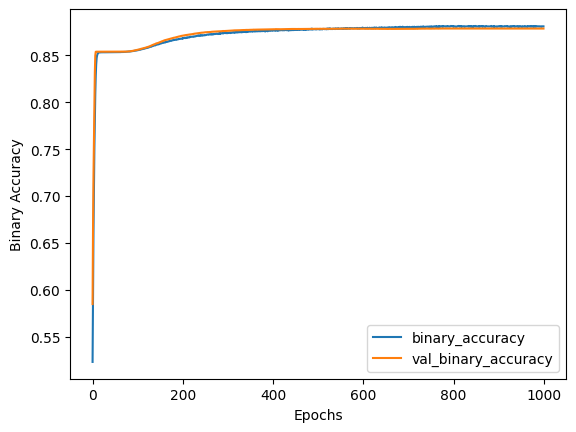

In [1208]:
plt.plot(res.history['binary_accuracy'], label='binary_accuracy')
plt.plot(res.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.ylabel('Binary Accuracy')

# plt.plot(res.history['macro_f1'], label='macro_f1')
# plt.plot(res.history['val_macro_f1'], label='val_macro_f1')
# plt.ylabel('Macro F1')

plt.xlabel('Epochs')
plt.legend()
plt.show()

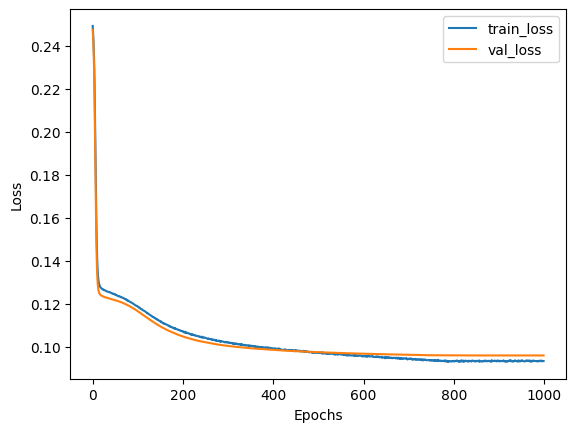

In [1209]:
plt.plot(res.history['loss'], label='train_loss')
plt.plot(res.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# val_loss: 0.6336

# Predict

In [1210]:
df_product

,product_id,category,brand,kind,ratings,price
0,0,Dress,Adidas,Kids' Fashion,3.270463,53.916667
1,1,Dress,Adidas,Men's Fashion,2.879264,44.500000
2,2,Dress,Adidas,Women's Fashion,2.673620,47.666667
3,3,Dress,Gucci,Kids' Fashion,3.689981,50.200000
4,4,Dress,Gucci,Men's Fashion,3.282323,51.125000
...,...,...,...,...,...,...
70,70,T-shirt,Nike,Men's Fashion,2.436425,56.500000
71,71,T-shirt,Nike,Women's Fashion,2.636504,72.166667
72,72,T-shirt,Zara,Kids' Fashion,3.548573,65.750000
73,73,T-shirt,Zara,Men's Fashion,2.520955,52.818182


In [1218]:
customer_id = 1
products_on_chart = df_dataset[df_dataset['customer_id'] == customer_id]['product_id'].unique().tolist()
products_on_chart

[22, 39, 45, 17, 33, 30, 18, 69, 25]

In [1303]:
# Input: from dataset
idx = 10
input_arr = x_test[idx]
output_arr = y_test[idx]
products_on_chart = np.argwhere(input_arr > 0.5).reshape(-1).tolist()
products_truth = np.argwhere(output_arr > 0.5).reshape(-1).tolist()

# Input: manual select
# products_on_chart = [70, ]
products_on_chart = [0, 1]
products_truth = products_on_chart
input_arr = np.zeros((1, total_product))
input_arr[0, products_on_chart] = 1
# for id in products_on_chart:
    # input_arr[0, id] = 1

# # Input From Customer
# customer_id = 4
# products_on_chart = df_dataset[df_dataset['customer_id'] == customer_id]['product_id'].unique().tolist()
# products_truth = products_on_chart

print(f'Items on your chart: ')
df_product.iloc[products_on_chart]

Items on your chart: 


,product_id,category,brand,kind,ratings,price
0,0,Dress,Adidas,Kids' Fashion,3.270463,53.916667
1,1,Dress,Adidas,Men's Fashion,2.879264,44.500000


In [1304]:
# input_arr[:, products_on_chart] = 2

In [1306]:
input_arr

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [1307]:
print(f'Another Product you actualy buy:')
df_product_act = df_product.iloc[products_truth].copy()
df_product_act

Another Product you actualy buy:


,product_id,category,brand,kind,ratings,price
0,0,Dress,Adidas,Kids' Fashion,3.270463,53.916667
1,1,Dress,Adidas,Men's Fashion,2.879264,44.500000


In [1308]:
x_input = np.array([input_arr, ])
pred = autoencoder(x_input)

# pred_ids = np.argwhere(pred[0] > 0.5).reshape(-1).tolist()

df_product_pred = df_product.copy()
df_product_pred['Score'] = pred.numpy()[0]
df_product_pred['Correct'] = df_product_pred['product_id'].isin(df_product_act['product_id'].tolist())

# df_product_pred[(df_product_pred['Score'] > 0.2)].sort_values(by=['Score'], ascending=False)
df_product_pred = df_product_pred[~df_product_pred['product_id'].isin(products_on_chart)]
df_product_pred = df_product_pred.sort_values(by=['Score'], ascending=False).head(10)


print(f'Another product you might like:')
print(df_product_pred.shape)
df_product_pred

Another product you might like:
(10, 8)


,product_id,category,brand,kind,ratings,price,Score,Correct
24,24,Jeans,Nike,Kids' Fashion,2.461879,56.650000,0.429233,False
72,72,T-shirt,Zara,Kids' Fashion,3.548573,65.750000,0.370171,False
21,21,Jeans,H&M,Kids' Fashion,2.813687,56.857143,0.365256,False
26,26,Jeans,Nike,Women's Fashion,2.710139,54.875000,0.333732,False
68,68,T-shirt,H&M,Women's Fashion,2.673312,43.538462,0.330870,False
43,43,Shoes,Zara,Men's Fashion,2.468021,55.388889,0.320512,False
15,15,Jeans,Adidas,Kids' Fashion,2.591739,51.600000,0.310816,False
14,14,Dress,Zara,Women's Fashion,3.071304,62.571429,0.277801,False
28,28,Jeans,Zara,Men's Fashion,3.153564,50.789474,0.270499,False
41,41,Shoes,Nike,Women's Fashion,2.681958,66.176471,0.263458,False


In [1269]:
x_input

array([[[0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [1270]:
pred

<tf.Tensor: shape=(1, 75), dtype=float32, numpy=
array([[0.03549025, 0.03008403, 0.04218327, 0.7937713 , 0.39259616,
        0.7036501 , 0.11470842, 0.10842402, 0.42239547, 0.08023383,
        0.06155409, 0.33042544, 0.008607  , 0.20189787, 0.06807294,
        0.02369922, 0.3430141 , 0.1357131 , 0.37729785, 0.04174098,
        0.09679006, 0.06729826, 0.04275778, 0.01248185, 0.11567681,
        0.27785113, 0.00569219, 0.04346628, 0.0580584 , 0.14379571,
        0.2885237 , 0.44866285, 0.0528258 , 0.2642989 , 0.01665205,
        0.23062144, 0.06537809, 0.02831221, 0.0196442 , 0.06838156,
        0.04806912, 0.05659426, 0.20029353, 0.20326865, 0.02027381,
        0.0228399 , 0.01253361, 0.02480413, 0.02605806, 0.05771708,
        0.16113387, 0.66384274, 0.5133173 , 0.03055782, 0.03579544,
        0.08307961, 0.00318655, 0.12704316, 0.36204568, 0.00585675,
        0.13101222, 0.10840213, 0.00461842, 0.02037658, 0.05074368,
        0.02183163, 0.2505927 , 0.00546964, 0.12083121, 0.71644634,

In [1178]:
# df_product_pred.sort_values(by=['Score'], ascending=False).head(10)